In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as fn
from torch.autograd import Variable
import matplotlib
import torch.nn.functional as F 
import numpy as np
import pickle

import matplotlib.pyplot as plt

In [2]:
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())


__Python VERSION: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 18:21:58) 
[GCC 7.2.0]
__pyTorch VERSION: 0.4.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2015 NVIDIA Corporation
Built on Tue_Aug_11_14:27:32_CDT_2015
Cuda compilation tools, release 7.5, V7.5.17
__CUDNN VERSION: 7102
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [3]:
train_xyz = []

with open('training/8v/data.pickle', 'rb') as f:
    data = pickle.load(f)

for i in range(len(data)):
    obj = np.asarray(data[i])
    #print("obj: ", obj)
    nv = 8
    dim = 36
    #print(obj.shape)
    train_xyz.append((obj))
    #print(train_xyz)
train_xyz = torch.Tensor(train_xyz)
train_xyz.shape  

torch.Size([10000, 3, 36])

In [4]:
test_xyz = []

with open('test/8v/data.pickle', 'rb') as f:
    data = pickle.load(f)

for i in range(len(data)):
    obj = np.asarray(data[i])
    #print("obj: ", obj)
    nv = 8
    dim = 36
    #print(obj.shape)
    test_xyz.append((obj))
    #print(train_xyz)
test_xyz = torch.Tensor(test_xyz)
test_xyz.shape  

torch.Size([1000, 3, 36])

In [5]:
train_xy = []

with open('training/8v/data.pickle', 'rb') as f:
    data = pickle.load(f)
    
for i in range(len(data)):
    obj = np.asarray(data[i])
    obj[2,0:8]=np.random.rand(8)
    train_xy.append(obj)
    #print(train_xyz)
train_xy = torch.Tensor(train_xy)
train_xy.shape        

torch.Size([10000, 3, 36])

In [6]:
test_xy = []

with open('test/8v/data.pickle', 'rb') as f:
    data = pickle.load(f)
    
for i in range(len(data)):
    obj = np.asarray(data[i])
    #print(obj.shape)
    #print("prev:", obj)
    obj[2,0:8]=np.random.rand(8)
    #print("rand:",obj)
    test_xy.append(obj)
    #print(train_xyz)
test_xy = torch.Tensor(test_xy)
test_xy.shape        

torch.Size([1000, 3, 36])

In [7]:
# new version
import torch.nn.functional as F 
from functools import reduce

def num_edges(n):
    return int(n*(n-1)/2)

class DepthEstNet(nn.Module):    
    def __init__(self, vertices, nonlinearity = fn.tanh, additional_hidden_wide=0):
        super(DepthEstNet, self).__init__()
        self.vertices = vertices
        input_dim = vertices * 3
        self.edges = int(num_edges(vertices))
        edge_dim = self.edges * 3
        edges = self.edges
        self.conv_edge_vec = nn.ModuleList()
        self.conv_edge_num = vertices-1
        
        self.fc0 = nn.Linear(vertices, vertices)
        #self.conv_edge_vec.append(fc0)
        
#torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)

        for i in range(1,vertices):
            m = nn.Conv1d(3, 3, 2, stride=1, dilation=i)
            m.weight = torch.nn.Parameter(torch.from_numpy(np.array(
            [[[1, -1],
             [0, 0],
             [0, 0]],
    
            [[0, 0],
             [1,-1],
             [0,0]],

            [[0,  0],
             [0, 0],
             [1, -1]]], dtype=np.float32)))
            m.bias = torch.nn.Parameter(torch.from_numpy(np.array([0,0,0], dtype=np.float32)))
            m.requires_grad = False
            self.conv_edge_vec.append(m)
        
#torch.nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, 
#groups=1, bias=True, dilation=1)
        
        self.deconv_edge_vec = nn.ModuleList()
        self.deconv_edge_num = vertices-1
        for i in range(1,vertices):
            m = nn.Conv1d(3, 3, 2, stride=1, dilation=vertices-i)
            m.requires_grad = True
            self.deconv_edge_vec.append(m)        
        
        
        self.reverse_learn_params = nn.ModuleList()
        fc1 = nn.Linear(edges, edges*10)
        self.reverse_learn_params.append(fc1)
        fc2 = nn.Linear(edges*10, edges*20)
        self.reverse_learn_params.append(fc2)
        fc3 = nn.Linear(edges*20, vertices*20)
        self.reverse_learn_params.append(fc3)        
        fc4 = nn.Linear(vertices*20, vertices*10)
        self.reverse_learn_params.append(fc4)
        fc5 = nn.Linear(vertices*10, vertices)
        self.reverse_learn_params.append(fc5)
        
        self.layernorm = nn.LayerNorm(edges)
        self.nonlinearity = nonlinearity
        self.cos = nn.CosineSimilarity(dim=0, eps=1e-6)


    def forward(self, x, extract_x=False, extract_y=False, extract_z=False):
        #print("initial x", x)
        n,d,t = x.size()
        #print(n,d,v)
        x,conn = torch.Tensor.split(x,[self.vertices,t-self.vertices],dim=2)
        
        #x_mod = F.sigmoid(self.fc0(x))
        #new_x = torch.tensor(x_mod.data)
        
        for i in range(self.conv_edge_num):
            y = self.conv_edge_vec[i](x)
            if (i==0):
                output = y
            else:
                output = torch.cat((output,y), dim=2)
        
        #print("connections:", conn)
        #print("bitwise and:", conn*output)
        
        
        
        #for i in range(self.deconv_edge_num):
        #    y = self.deconv_edge_vec[i](output)
        #    y = self.nonlinearity(y)
            #print("deconv output:",y, "shape:", y.shape)
            
            
        x_vec =  output[:,0,:] 

        temp = (self.reverse_learn_params[0](x_vec))
        temp = (self.reverse_learn_params[1](temp))
        temp = (self.reverse_learn_params[2](temp))
        temp = (self.reverse_learn_params[3](temp))
        vertexs_recovered = (self.reverse_learn_params[4](temp))
        optimizer = torch.optim.SGD(self.reverse_learn_params.parameters(), lr = 1e-1 , momentum=0.8)
        criterion = nn.MSELoss()
        optimizer.zero_grad()
        #print(" vertexs_recovered:", vertexs_recovered)
        #print(" x[:,0,:]:", x[:,0,:])
        loss = criterion(vertexs_recovered, x[:,0,:])
        #print("loss", loss)
        loss.backward(retain_graph=True)
        optimizer.step()
          
        y=output
        output = output*conn
        
        if (extract_x):
            vec = output[:,0,:] #y[i,0,:]
            print("x output vec:", vec)
            temp = (self.reverse_learn_params[0](vec))
            temp = (self.reverse_learn_params[1](temp))
            temp = (self.reverse_learn_params[2](temp))
            temp = (self.reverse_learn_params[3](temp))
            vertexs_recovered = (self.reverse_learn_params[4](temp))
            return vertexs_recovered        
        
        if (extract_y):
            vec = output[:,1,:] #y[i,0,:]
            print("y output vec:", vec)
            temp = (self.reverse_learn_params[0](vec))
            temp = (self.reverse_learn_params[1](temp))
            temp = (self.reverse_learn_params[2](temp))
            temp = (self.reverse_learn_params[3](temp))
            vertexs_recovered = (self.reverse_learn_params[4](temp))
            return vertexs_recovered          
            
        if (extract_z):
            vec = output[:,2,:] #y[i,0,:]
            print("z output vec:", vec)
            temp = (self.reverse_learn_params[0](vec))
            temp = (self.reverse_learn_params[1](temp))
            temp = (self.reverse_learn_params[2](temp))
            temp = (self.reverse_learn_params[3](temp))
            vertexs_recovered = (self.reverse_learn_params[4](temp))
            return vertexs_recovered  
        
                
        #print("output: ",output)
        n,d,e = output.size()            
        output = F.normalize(output, p=2, dim=1)
        #print("normalized output",output)
        #pool all dimensions for Gram Matrix
        n,d,e = output.size()
        output = [torch.mm(mat.transpose(1,0),mat) for mat in output[:]]
        #print(type(output))
        return torch.stack(output)

In [8]:
#cuboid object

data = [[
         [0.60555981397628784, 1.019606590270996, 0.9311475157737732], 
         [0.7988362312316895, 0.14085637032985687, 1.1584558486938477], 
         [0.83646029531955719, 0.9592991471290588, 1.0384680032730103], 
         [1.040856385231018, 0.20116375386714935, 0.8111595511436462]]]

obj = np.asarray(data,dtype=np.float32)
obj.shape
nv = obj.shape[1]
obj = obj.T.reshape(1,3,nv)
obj = torch.tensor(obj)

print(type(obj))
print(obj.shape)

conn = torch.from_numpy(np.asarray([[[1,1,1,0,0,1],[1,1,1,0,0,1],[1,1,1,0,0,1]]],dtype=np.float32))

print(type(conn))
print(conn.shape)

input =  torch.cat((obj,conn), dim=2)

print(input)

<class 'torch.Tensor'>
torch.Size([1, 3, 4])
<class 'torch.Tensor'>
torch.Size([1, 3, 6])
tensor([[[ 0.6056,  0.7988,  0.8365,  1.0409,  1.0000,  1.0000,  1.0000,
           0.0000,  0.0000,  1.0000],
         [ 1.0196,  0.1409,  0.9593,  0.2012,  1.0000,  1.0000,  1.0000,
           0.0000,  0.0000,  1.0000],
         [ 0.9311,  1.1585,  1.0385,  0.8112,  1.0000,  1.0000,  1.0000,
           0.0000,  0.0000,  1.0000]]])


In [9]:
model = DepthEstNet(nv, nonlinearity=fn.sigmoid, additional_hidden_wide=1)
criterion = nn.L1Loss()

#print(model)
#print(list(model.parameters())[:])
model.forward(torch.Tensor(input))

tensor([[[ 1.0000, -0.9620,  0.8622,  0.0000,  0.0000,  0.8946],
         [-0.9620,  1.0000, -0.8650,  0.0000,  0.0000, -0.8257],
         [ 0.8622, -0.8650,  1.0000,  0.0000,  0.0000,  0.9642],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.8946, -0.8257,  0.9642,  0.0000,  0.0000,  1.0000]]])

In [116]:
model = DepthEstNet(8, nonlinearity=fn.relu, additional_hidden_wide=1)
criterion = nn.L1Loss()
print(model)

DepthEstNet(
  (conv_edge_vec): ModuleList(
    (0): Conv1d(3, 3, kernel_size=(2,), stride=(1,))
    (1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(3,))
    (3): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(4,))
    (4): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(5,))
    (5): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(6,))
    (6): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(7,))
  )
  (fc0): Linear(in_features=8, out_features=8, bias=True)
  (deconv_edge_vec): ModuleList(
    (0): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(7,))
    (1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(6,))
    (2): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(5,))
    (3): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(4,))
    (4): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(3,))
    (5): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilatio

In [117]:
train_xyz[1000,:,:]

tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.1290, -0.0706, -0.1290,  0.1504, -0.8558, -1.0554, -1.1139,
         -0.8344,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.6691,  0.9135, -0.6691, -0.5000,  0.6691,  0.9135, -0.6691,
         -0.5000,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,

In [118]:
print(list(model.parameters())[:])

[Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([ 0.,  0.,  0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([ 0.,  0.,  0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([ 0.,  0.,  0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [

Training #1

In [119]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(train_xy[:,:,:], train_xyz[:,:,:])
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

cuda:0


/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


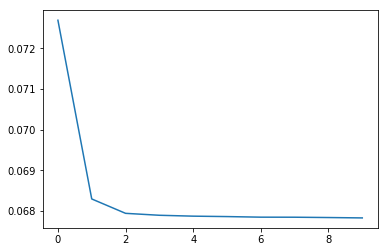

In [120]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
model.to(device)

lr, epochs, batch_size = 1e-1 , 10 , 100
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
train_accum=[]
i = 0
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        i =  i+1
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        output = model.forward(local_xy)
        output = output.to(device)
        #print(output)
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        #print(local_xy, local_xyz)
        #if (i%500 == 0): print("network loss -> ", loss)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    train_accum.append(np.mean(localaccum))
plt.plot(train_accum);                      

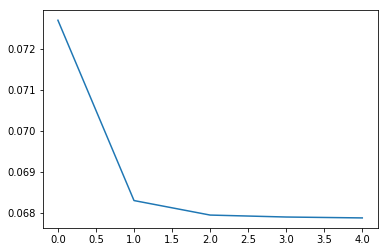

In [125]:
plt.plot(train_accum[0:5]);

In [126]:
train_accum

[0.07268874,
 0.0682967,
 0.0679433,
 0.0678957,
 0.06787384,
 0.0678636,
 0.06784907,
 0.06784784,
 0.06784002,
 0.06783069]

TEST BY RENDERING

In [102]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
    
def test_reconstruct(N):
    print(N)
    print("******************************")
    fig = plt.figure()
    ax = Axes3D(fig)

    test_obj=test_xyz[N,:,:]
    d,t = test_obj.size()
    obj,conn = torch.Tensor.split(test_obj,[8,t-8],dim=1)
    #print(obj)
    #print(conn)
    fullobj = np.concatenate((obj,conn), axis=1)
    computed_z = model.forward(torch.Tensor([fullobj]).to(device), extract_z=True)
    orig_z = obj[2]


    print("_________ORIG________")

    x=obj[0]
    y=obj[1]
    z=obj[2]


    x=[(i-min(x))/(max(x)-min(x)) for i in x]
    y=[(i-min(y))/(max(y)-min(y)) for i in y]
    z=[(i-min(z))/(max(z)-min(z)) for i in z]

    verts = [list(zip(x, y,z))]
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='r', marker='o')
    plt.show()


    print("_________RECON________")

    fig = plt.figure()
    ax = Axes3D(fig)
    x=obj[0]
    y=obj[1]
    z=computed_z.to('cpu').detach().numpy()[0]
    #print("Test  obj's   z: ", obj[2])
    #print("Model computed z:", z)

    x=[(i-min(x))/(max(x)-min(x)) for i in x]
    y=[(i-min(y))/(max(y)-min(y)) for i in y]
    z=[(i-min(z))/(max(z)-min(z)) for i in z]

    verts = [list(zip(x, y,z))]
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='r', marker='o')
    plt.show()



In [103]:
N=[15,]

50
******************************
z output vec: tensor([[-1.0672, -0.9106, -2.5564, -0.0000, -1.0795, -0.9229, -2.5688,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.9512,
          0.0000,  0.0000, -0.0000,  2.3076, -0.0005,  0.0007,  0.0023,
          0.0009,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


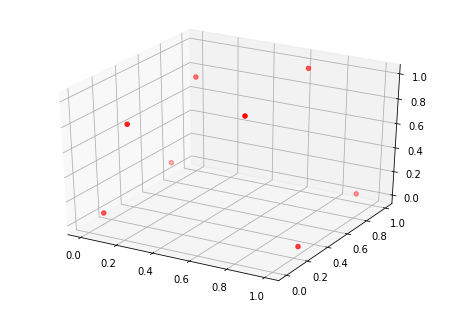

_________RECON________


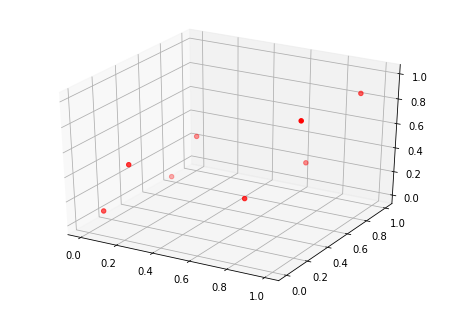

51
******************************
z output vec: tensor([[-0.8605, -1.3156, -2.5164, -0.0000, -0.8729, -1.3280, -2.5287,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.5594,
          0.0000, -0.0000,  0.0000,  1.9158, -0.0004,  0.0012,  0.0027,
          0.0009,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


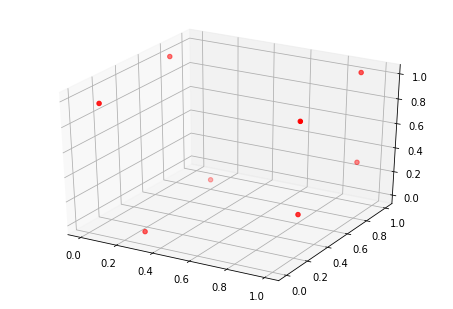

_________RECON________


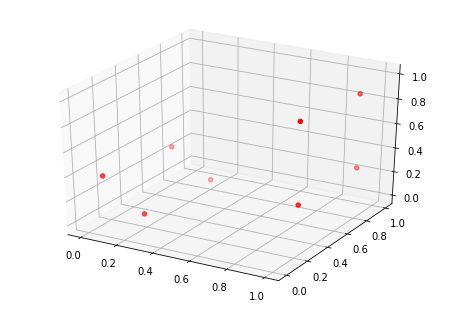

52
******************************
z output vec: tensor([[-1.4830, -0.8673, -2.5564, -0.0000, -1.4954, -0.8796, -2.5688,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.6242,
          0.0000,  0.0000, -0.0000,  1.9806, -0.0005, -0.0001,  0.0023,
          0.0009, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


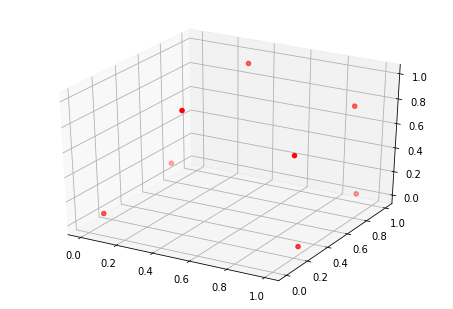

_________RECON________


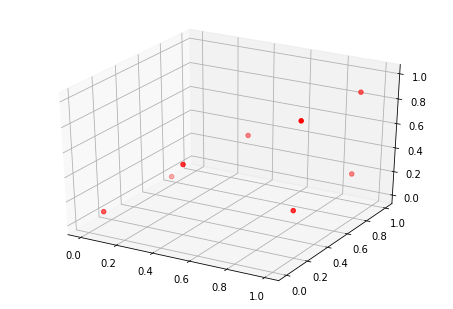

53
******************************
z output vec: tensor([[-0.8074, -1.3263, -2.5164, -0.0000, -0.8198, -1.3387, -2.5287,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  2.0766,
          0.0000, -0.0000,  0.0000,  2.4329, -0.0003,  0.0020,  0.0027,
          0.0009,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


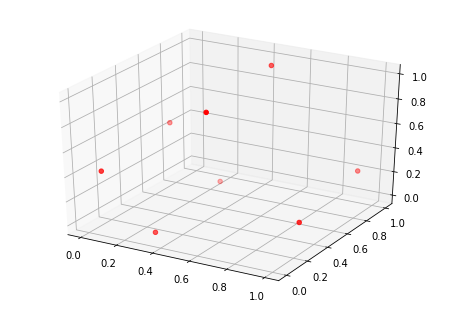

_________RECON________


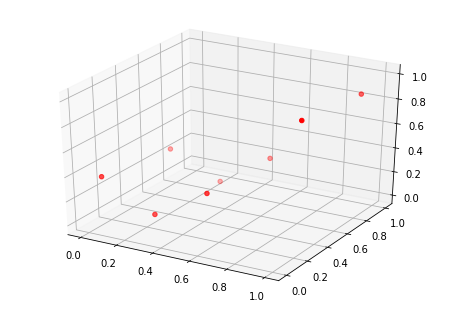

54
******************************
z output vec: tensor([[-1.0864, -1.4373, -2.5024, -0.0000, -1.0988, -1.4497, -2.5147,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.7854,
          0.0000, -0.0000,  0.0000,  2.1418, -0.0006,  0.0006,  0.0026,
          0.0009,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


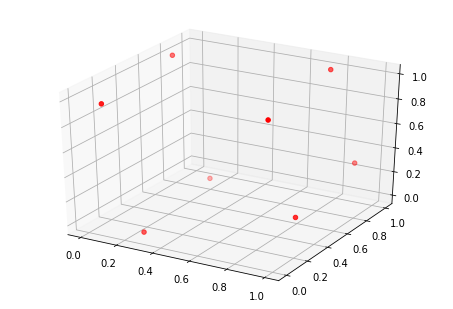

_________RECON________


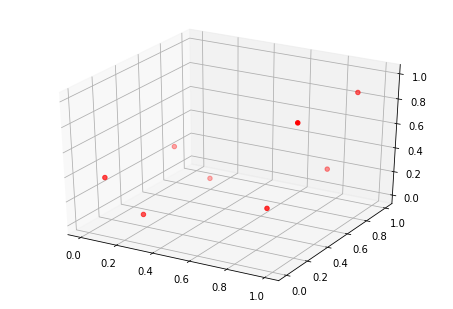

55
******************************
z output vec: tensor([[-1.2926, -0.8458, -2.5612, -0.0000, -1.3049, -0.8582, -2.5736,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.6991,
          0.0000,  0.0000, -0.0000,  2.0555, -0.0005,  0.0002,  0.0021,
          0.0009, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


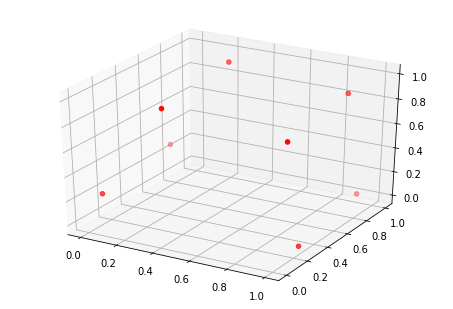

_________RECON________


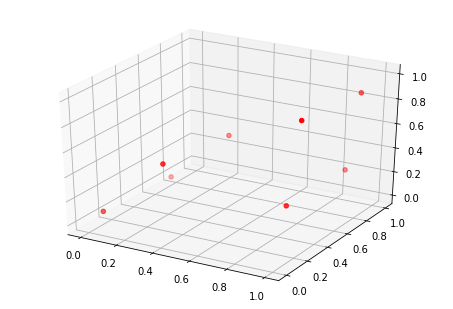

56
******************************
z output vec: tensor([[-1.0672, -0.9106, -2.5564, -0.0000, -1.0795, -0.9229, -2.5688,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.9512,
          0.0000,  0.0000, -0.0000,  2.3076, -0.0005,  0.0007,  0.0023,
          0.0009,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


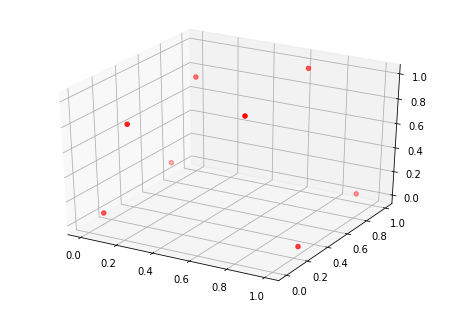

_________RECON________


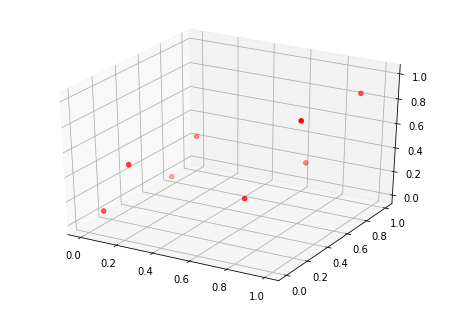

57
******************************
z output vec: tensor([[-0.9374, -1.3156, -2.5164, -0.0000, -0.9497, -1.3280, -2.5287,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  2.0766,
          0.0000, -0.0000,  0.0000,  2.4329, -0.0003,  0.0012,  0.0027,
          0.0009,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


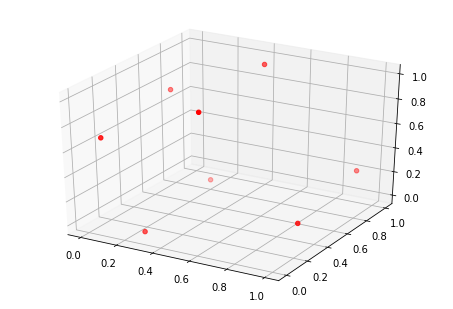

_________RECON________


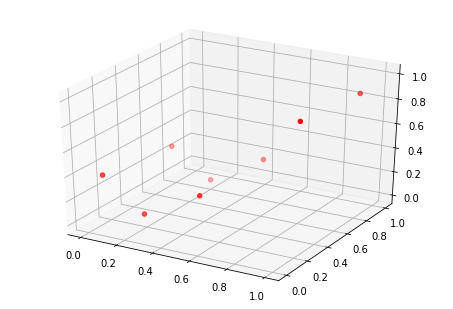

58
******************************
z output vec: tensor([[-0.8605, -1.7628, -2.4723, -0.0000, -0.8729, -1.7752, -2.4847,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.5594,
          0.0000, -0.0000,  0.0000,  1.9158, -0.0004,  0.0012,  0.0024,
          0.0009,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


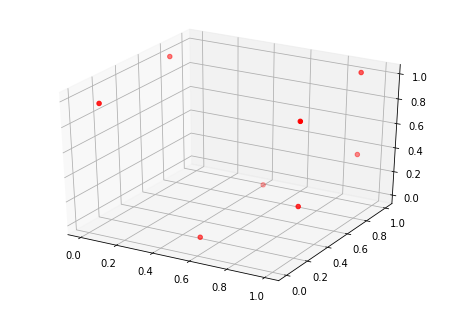

_________RECON________


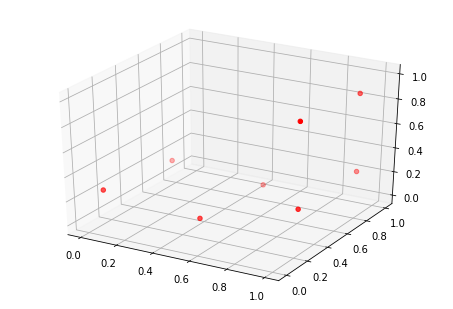

59
******************************
z output vec: tensor([[-1.0672, -0.9106, -2.5564, -0.0000, -1.0795, -0.9229, -2.5688,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.9512,
          0.0000,  0.0000, -0.0000,  2.3076, -0.0005,  0.0007,  0.0023,
          0.0009,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


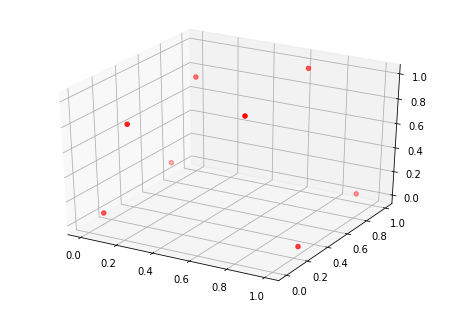

_________RECON________


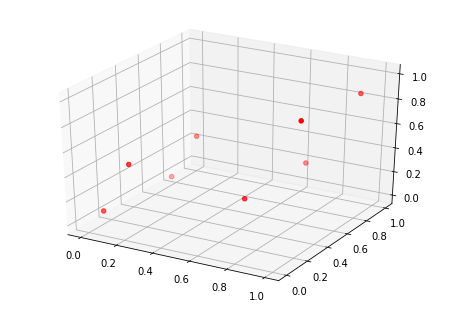

In [105]:
for i in range(50,60):
    test_reconstruct(i)

In [76]:
orig_obj = [[  0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265],
        [ 0.1290, -0.0706, -0.1290,  0.1504, -0.8558, -1.0554, -1.1139,
         -0.8344 ],
        [ 0.6691,  0.9135, -0.6691, -0.5000,  0.6691,  0.9135, -0.6691,
         -0.5000 ]]

In [413]:
obj = [[[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.1290, -0.0706, -0.1290,  0.1504, -0.8558, -1.0554, -1.1139,
         -0.8344,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.6691,  0.9135, -0.6691, -0.5000,  0.6691,  0.9135, -0.6691,
         -0.5000,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000]]]

model.forward(torch.Tensor(obj).to(device), extract_x=True)


 vertexs_recovered: tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-10 *
       8.5670, device='cuda:0')
x output vec: tensor([[ 1.1325,  0.3313, -1.5848, -0.0000,  1.1324,  0.3313, -1.5847,
          0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.1210,
         -0.0000, -0.0000,  0.0000, -0.1210, -0.1736, -0.1737, -0.1737,
         -0.1736,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000]], device='cuda:0')


tensor([[ 0.7588,  0.5156,  0.2792,  0.7124,  0.8580,  0.6369,  0.4585,
          0.8284]], device='cuda:0')

In [414]:
model.forward(torch.Tensor(obj).to(device), extract_y=True)


 vertexs_recovered: tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-10 *
       3.9415, device='cuda:0')
y output vec: tensor([[ 0.1996,  0.0584, -0.2794,  0.0000,  0.1996,  0.0585, -0.2795,
          0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0214,
          0.0000,  0.0000,  0.0000, -0.0214,  0.9848,  0.9848,  0.9849,
          0.9848,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')


tensor([[ 0.5512,  0.4247,  0.4220,  0.5998,  0.6448,  0.5961,  0.4953,
          0.6490]], device='cuda:0')

In [415]:
model.forward(torch.Tensor(obj).to(device), extract_z=True)


 vertexs_recovered: tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-10 *
       2.2148, device='cuda:0')
z output vec: tensor([[-0.2444,  1.5826, -0.1691, -0.0000, -0.2444,  1.5826, -0.1691,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.1691,
          0.0000, -0.0000,  0.0000,  1.1691,  0.0000,  0.0000,  0.0000,
          0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')


tensor([[ 1.0587,  1.2730,  0.7061,  0.8346,  1.1649,  1.4251,  0.9184,
          0.9816]], device='cuda:0')

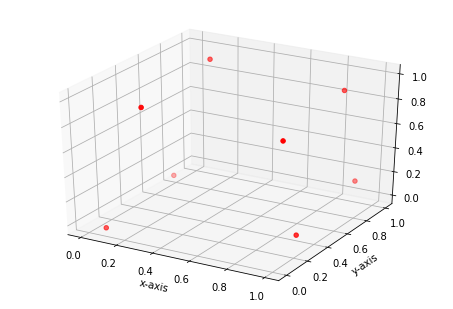

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)

x = [ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265 ]
y =  [ 0.1290, -0.0706, -0.1290,  0.1504, -0.8558, -1.0554, -1.1139,
         -0.8344 ]
z =  [ 0.6691,  0.9135, -0.6691, -0.5000,  0.6691,  0.9135, -0.6691,
        -0.5000 ]

x=[(i-min(x))/(max(x)-min(x)) for i in x]

y=[(i-min(y))/(max(y)-min(y)) for i in y]

z=[(i-min(z))/(max(z)-min(z)) for i in z]

verts = [list(zip(x, y,z))]
#ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(x, y, z, c='r', marker='o')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
#plt.zlabel('z-axis')
plt.show()

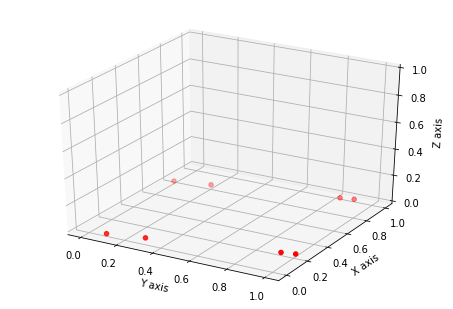

In [47]:
# for the report - delete later

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)

x = [ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265 ]
y =  [ 0.1290, -0.0706, -0.1290,  0.1504, -0.8558, -1.0554, -1.1139,
         -0.8344 ]
z =  [ 0.0,  0.0, 0.0, 0.0,  0.0,  0.0, 0.0001,
        0.0 ]
#z = [-1,-1,-1,-1,-1,-1,-1,-1]

x=[(i-min(x))/(max(x)-min(x)) for i in x]

y=[(i-min(y))/(max(y)-min(y)) for i in y]

z=[(i-min(z))/(1) for i in z]

verts = [list(zip(x, y, z))]
#ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(x, y, z, c='r', marker='o')
ax.set_xlabel('Y axis')
ax.set_ylabel('X axis')
ax.set_zlabel('Z axis')
ax.set_zlim(0, 1)
plt.show()

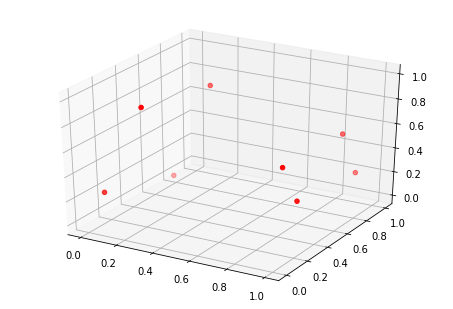

In [416]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
x = [ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265 ]
y =  [ 0.1290, -0.0706, -0.1290,  0.1504, -0.8558, -1.0554, -1.1139,
         -0.8344 ]
z = [ 1.0587,  1.2730,  0.7061,  0.8346,  1.1649,  1.4251,  0.9184,
          0.9816]
x=[(i-min(x))/(max(x)-min(x)) for i in x]
y=[(i-min(y))/(max(y)-min(y)) for i in y]
z=[(i-min(z))/(max(z)-min(z)) for i in z]

verts = [list(zip(x, y,z))]
#ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(x, y, z, c='r', marker='o')
plt.show()

Trial #2

cuda:0
 vertexs_recovered: tensor([[ 0.2903, -0.8529, -0.6698,  0.8529,  0.4639, -0.6792, -0.4961,
          1.0265]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.6698,  0.8529,  0.4639, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-10 *
       9.1400, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3671, -0.9287, -0.0926,  0.8529,  0.5409, -0.7552,  0.0808,
          1.0265]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9306, -0.0936,  0.8529,  0.5397, -0.7570,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       1.4282, device='cuda:0')
 vertexs_recovered: tensor([[-0.4006, -0.9800, -0.2055,  0.8524, -0.2272, -0.8067, -0.0321,
          1.0258]], device='cuda:0')
 x[:,0,:]: tensor([[-0.4006, -0.9794, -0.2048,  0.8529, -0.2269, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-07 *
       4.5910, device='cuda:0')
 vertexs_recovered: tensor([[-0.1851, -0.9552, -0.6071,  0.8540, -0.0111

/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 vertexs_recovered: tensor([[ 0.7252, -0.8599, -0.2126,  0.8499,  0.8977, -0.6877, -0.0396,
          1.0225]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.8529, -0.2048,  0.8529,  0.9055, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.8027, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2090, -0.8500, -0.2026,  0.8526,  0.3820, -0.6765, -0.0279,
          1.0262]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.2048,  0.8529,  0.3784, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       7.6990, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8880, -0.7117, -0.7651,  0.8499,  1.0610, -0.5378, -0.5924,
          1.0226]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.7102, -0.7628,  0.8529,  1.0634, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       6.4362, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2097, -0.8518, -0.2040,  0.8542,  0.3832, -0.67

 vertexs_recovered: tensor([[-0.1784, -0.9514, -0.6019,  0.8549, -0.0035, -0.7770, -0.4275,
          1.0301]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9570, -0.6088,  0.8529, -0.0127, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.2914, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3583, -0.6873, -0.9382,  0.8496,  0.5314, -0.5155, -0.7654,
          1.0223]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.9306,  0.8529,  0.5397, -0.5059, -0.7570,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.4484, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8627, -0.4804, -0.8432,  0.8576,  1.0377, -0.3059, -0.6673,
          1.0336]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.8529,  0.8529,  1.0265, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.0479, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1444, -0.9613, -0.7757,  0.8469,  0.3166, -0.78

 vertexs_recovered: tensor([[ 0.1574, -0.9644, -0.3849,  0.8530,  0.3300, -0.7906, -0.2106,
          1.0265]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9649, -0.3860,  0.8529,  0.3316, -0.7913, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-07 *
       9.9245, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8851, -0.7152, -0.7683,  0.8517,  1.0586, -0.5415, -0.5949,
          1.0251]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.7102, -0.7628,  0.8529,  1.0634, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.9774, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3748, -0.6776, -0.9257,  0.8565,  0.5488, -0.5024, -0.7478,
          1.0320]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.9306,  0.8529,  0.5397, -0.5059, -0.7570,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.1165, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7952, -0.1955, -0.9380,  0.8466,  0.9664, -0.02

 vertexs_recovered: tensor([[ 0.1615, -0.9603,  0.0824,  0.8528,  0.3343, -0.7872,  0.2565,
          1.0263]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9649,  0.0792,  0.8529,  0.3316, -0.7913,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.0063, device='cuda:0')
 vertexs_recovered: tensor([[-0.1869, -0.9344, -0.0982,  0.8515, -0.0136, -0.7619,  0.0765,
          1.0253]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9306, -0.0936,  0.8529, -0.0127, -0.7570,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       9.4768, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8473, -0.8542, -0.4957,  0.8521,  1.0206, -0.6805, -0.3237,
          1.0248]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.4924,  0.8529,  1.0265, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.3583, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2931, -0.8503, -0.2853,  0.8550,  0.4676, -0.67

 vertexs_recovered: tensor([[ 0.6064, -0.2974, -0.7492,  0.8569,  0.7824, -0.1227, -0.5729,
          1.0339]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.3119, -0.7628,  0.8529,  0.7653, -0.1382, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.8559, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7885, -0.9690, -0.1082,  0.8474,  0.9586, -0.7985,  0.0638,
          1.0180]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.0936,  0.8529,  0.9758, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.7909, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1703, -0.9323, -0.7488,  0.8594,  0.3470, -0.7552, -0.5739,
          1.0358]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459, -0.7628,  0.8529,  0.3316, -0.7723, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.7775, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8540, -0.8529, -0.0039,  0.8513,  1.0271, -0.67

 vertexs_recovered: tensor([[ 0.5836, -0.7191, -0.7734,  0.8460,  0.7547, -0.5484, -0.6022,
          1.0169]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.7628,  0.8529,  0.7653, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.0186, device='cuda:0')
 vertexs_recovered: tensor([[-0.3822, -0.9609, -0.1874,  0.8572, -0.2086, -0.7869, -0.0113,
          1.0329]], device='cuda:0')
 x[:,0,:]: tensor([[-0.4006, -0.9794, -0.2048,  0.8529, -0.2269, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.6569, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3917, -0.9492, -0.5917,  0.8509,  0.5643, -0.7778, -0.4180,
          1.0233]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.9366, -0.5789,  0.8529,  0.5742, -0.7630, -0.4052,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1178, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5096, -0.8317, -0.4751,  0.8577,  0.6852, -0.65

loss tensor(1.00000e-04 *
       1.7839, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8048, -0.9531, -0.6085,  0.8542,  0.9783, -0.7792, -0.4339,
          1.0275]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.6088,  0.8529,  0.9758, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       6.2748, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8083, -0.1826, -0.5994,  0.8565,  0.9841, -0.0079, -0.4260,
          1.0321]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.6088,  0.8529,  0.9758, -0.0127, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.4560, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2851, -0.9880, -0.2991,  0.8471,  0.4561, -0.8157, -0.1257,
          1.0188]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821, -0.2903,  0.8529,  0.4639, -0.8084, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.3768, device='cuda:0')
 vertexs_recovered: t

 vertexs_recovered: tensor([[ 0.5941, -0.3124, -0.7621,  0.8520,  0.7668, -0.1407, -0.5887,
          1.0257]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.3119, -0.7628,  0.8529,  0.7653, -0.1382, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       2.1337, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7274, -0.4048, -0.2058,  0.8504,  0.9009, -0.2327, -0.0336,
          1.0239]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.2048,  0.8529,  0.9055, -0.2269, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.4099, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4926, -0.8548, -0.4985,  0.8518,  0.6653, -0.6810, -0.3246,
          1.0244]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.0595, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6000, -0.3052, -0.7533,  0.8542,  0.7744, -0.13

 vertexs_recovered: tensor([[ 0.5020, -0.9738, -0.4826,  0.8589,  0.6783, -0.7965, -0.3083,
          1.0345]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.9848, -0.4924,  0.8529,  0.6661, -0.8112, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1088, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4844, -0.8630, -0.4994,  0.8473,  0.6553, -0.6915, -0.3281,
          1.0188]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.2491, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5067, -0.9665,  0.0113,  0.8588,  0.6809, -0.7920,  0.1875,
          1.0349]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -9.8481e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -8.1116e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.9397, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2765, -0.8747, 

 x[:,0,:]: tensor([[-0.4006, -0.9794, -0.2048,  0.8529, -0.2269, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.3608, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5033, -0.4764, -0.4788,  0.8584,  0.6786, -0.3011, -0.3039,
          1.0343]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.4924, -0.4924,  0.8529,  0.6661, -0.3188, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.6802, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8432, -0.8585, -0.0091,  0.8522,  1.0170, -0.6857,  0.1636,
          1.0248]], device='cuda:0')
 x[:,0,:]: tensor([[ 8.5287e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.0265e+00,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.5556, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8119, -0.9509, -0.5957,  0.8595,  0.9881, -0.7722, -0.4220,
          1.0343]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.6088, 

 vertexs_recovered: tensor([[ 0.6457, -0.9526, -0.3200,  0.8578,  0.8211, -0.7774, -0.1459,
          1.0336]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.9698, -0.3368,  0.8529,  0.8067, -0.7962, -0.1632,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.0983, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8484, -0.8665, -0.5059,  0.8496,  1.0190, -0.6948, -0.3328,
          1.0204]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.4924,  0.8529,  1.0265, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1658, device='cuda:0')
 vertexs_recovered: tensor([[ 0.0190, -0.8318,  0.0218,  0.8554,  0.1949, -0.6590,  0.1968,
          1.0319]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.3925, device='cuda:0')
 vertexs_recovered: tensor([[-0.0137, -0.8657, 

 vertexs_recovered: tensor([[ 0.5089, -0.9789, -0.4880,  0.8589,  0.6830, -0.8020, -0.3110,
          1.0343]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.9848, -0.4924,  0.8529,  0.6661, -0.8112, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.0661, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1505, -0.9710,  0.0744,  0.8469,  0.3230, -0.8005,  0.2466,
          1.0182]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9649,  0.0792,  0.8529,  0.3316, -0.7913,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.2848, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2862, -0.9767, -0.6698,  0.8548,  0.4607, -0.8020, -0.4958,
          1.0288]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821, -0.6698,  0.8529,  0.4639, -0.8084, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.3271, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2963, -0.9768, -0.2853,  0.8541,  0.4694, -0.80

 vertexs_recovered: tensor([[ 0.7526, -0.3767, -0.1791,  0.8574,  0.9279, -0.2025, -0.0036,
          1.0341]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.2048,  0.8529,  0.9055, -0.2269, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.4956, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5875, -0.7163, -0.7698,  0.8545,  0.7628, -0.5399, -0.5952,
          1.0273]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.7628,  0.8529,  0.7653, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.9836, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2948, -0.8379, -0.6575,  0.8549,  0.4694, -0.6636, -0.4839,
          1.0286]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.6698,  0.8529,  0.4639, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.0391, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5909, -0.7241, -0.3942,  0.8513,  0.7617, -0.55

 vertexs_recovered: tensor([[ 0.8528, -0.4952, -0.4965,  0.8544,  1.0276, -0.3212, -0.3218,
          1.0312]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.4924,  0.8529,  1.0265, -0.3188, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       8.2677, device='cuda:0')
 vertexs_recovered: tensor([[ 0.0037, -0.8385, -0.8415,  0.8591,  0.1811, -0.6632, -0.6660,
          1.0354]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -8.5287e-01,  8.5287e-01,  1.7365e-01,
         -6.7922e-01, -6.7922e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1921, device='cuda:0')
 vertexs_recovered: tensor([[ 0.9030, -0.5777, -0.6910,  0.8455,  1.0742, -0.4056, -0.5197,
          1.0167]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.9167, -0.5548, -0.6698,  0.8529,  1.0904, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.4072, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4155, -0.9178, 

 vertexs_recovered: tensor([[ 0.6704, -0.5642, -0.6737,  0.8496,  0.8434, -0.3913, -0.5008,
          1.0223]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.5548, -0.6698,  0.8529,  0.8435, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.2468, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7377, -0.3796, -0.9616,  0.8517,  0.9115, -0.2079, -0.7900,
          1.0278]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.9794,  0.8529,  0.9055, -0.2269, -0.8058,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.8030, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7003, -0.8899, -0.2366,  0.8478,  0.8742, -0.7148, -0.0658,
          1.0195]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.8529, -0.2048,  0.8529,  0.9055, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       8.6236, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8370, -0.1525, -0.5778,  0.8617,  1.0130,  0.01

 vertexs_recovered: tensor([[ 0.0100, -0.8463,  0.0056,  0.8530,  0.1824, -0.6730,  0.1800,
          1.0281]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.1403, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5900, -0.3200, -0.7769,  0.8541,  0.7626, -0.1498, -0.6012,
          1.0284]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.3119, -0.7628,  0.8529,  0.7653, -0.1382, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.9546, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5951, -0.3054, -0.7508,  0.8536,  0.7719, -0.1325, -0.5779,
          1.0280]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.3119, -0.7628,  0.8529,  0.7653, -0.1382, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.0653, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6484, -0.5634, 

 vertexs_recovered: tensor([[ 0.1599, -0.9531, -0.7711,  0.8533,  0.3335, -0.7770, -0.5947,
          1.0257]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459, -0.7628,  0.8529,  0.3316, -0.7723, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.2620, device='cuda:0')
 vertexs_recovered: tensor([[ 0.0119, -0.9722,  0.0143,  0.8553,  0.1852, -0.7993,  0.1887,
          1.0291]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -9.8481e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -8.1116e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.2722, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8596, -0.7353, -0.7908,  0.8390,  1.0291, -0.5633, -0.6201,
          1.0087]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.7102, -0.7628,  0.8529,  1.0634, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       7.0896, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6461, -0.6137, 

 vertexs_recovered: tensor([[ 0.0033, -0.8457,  0.0040,  0.8557,  0.1782, -0.6712,  0.1781,
          1.0308]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.6111, device='cuda:0')
 vertexs_recovered: tensor([[ 0.0056, -0.8467,  0.0110,  0.8568,  0.1801, -0.6737,  0.1841,
          1.0305]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.0432, device='cuda:0')
 vertexs_recovered: tensor([[ 0.0034, -0.9868,  0.0031,  0.8523,  0.1787, -0.8141,  0.1756,
          1.0258]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -9.8481e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -8.1116e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-06 *
       8.0322, 

 x[:,0,:]: tensor([[ 4.9240e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.4381, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8708, -0.8376, -0.4714,  0.8600,  1.0479, -0.6591, -0.2952,
          1.0359]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.4924,  0.8529,  1.0265, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.1818, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1459, -0.7303, -0.7775,  0.8452,  0.3151, -0.5588, -0.6034,
          1.0176]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.7102, -0.7628,  0.8529,  0.3316, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.3409, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7324, -0.7225, -0.5779,  0.8549,  0.9061, -0.5493, -0.4010,
          1.0312]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.7319, -0.5789, 

 vertexs_recovered: tensor([[ 0.8130, -0.6718, -0.0867,  0.8585,  0.9893, -0.4966,  0.0895,
          1.0357]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.6796, -0.0936,  0.8529,  0.9758, -0.5059,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.7428, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6353, -0.6270, -0.3292,  0.8516,  0.8069, -0.4565, -0.1565,
          1.0251]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.3368,  0.8529,  0.8067, -0.4594, -0.1632,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.9461, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8486, -0.4999, -0.8609,  0.8502,  1.0225, -0.3270, -0.6869,
          1.0232]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.8529,  0.8529,  1.0265, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.7525, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2974, -0.9745, -0.2842,  0.8581,  0.4728, -0.79

loss tensor(1.00000e-04 *
       1.8907, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4723, -0.8644, -0.8656,  0.8461,  0.6443, -0.6935, -0.6939,
          1.0166]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.8529,  0.8529,  0.6661, -0.6792, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.1690, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8925, -0.3049, -0.7628,  0.8574,  1.0689, -0.1313, -0.5868,
          1.0338]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.3119, -0.7628,  0.8529,  1.0634, -0.1382, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.6681, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1740, -0.7018, -0.7424,  0.8587,  0.3502, -0.5248, -0.5685,
          1.0338]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.7102, -0.7628,  0.8529,  0.3316, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.1828, device='cuda:0')
 vertexs_recovered: t

loss tensor(1.00000e-04 *
       1.0837, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4882, -0.4965, -0.8502,  0.8500,  0.6610, -0.3269, -0.6787,
          1.0214]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.4924, -0.8529,  0.8529,  0.6661, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.1011, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8502, -0.8504, -0.8595,  0.8561,  1.0246, -0.6743, -0.6844,
          1.0320]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.8529,  0.8529,  1.0265, -0.6792, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.9096, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8463, -0.4969, -0.8544,  0.8481,  1.0172, -0.3258, -0.6833,
          1.0190]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.8529,  0.8529,  1.0265, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.7269, device='cuda:0')
 vertexs_recovered: t

 vertexs_recovered: tensor([[ 0.4953, -0.9939, -0.5013,  0.8554,  0.6687, -0.8161, -0.3263,
          1.0284]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.9848, -0.4924,  0.8529,  0.6661, -0.8112, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.3442, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6041, -0.9271, -0.3680,  0.8558,  0.7799, -0.7526, -0.1935,
          1.0318]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.9459, -0.3860,  0.8529,  0.7653, -0.7723, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.2896, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5702, -0.7235, -0.4010,  0.8445,  0.7388, -0.5569, -0.2312,
          1.0136]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.3860,  0.8529,  0.7653, -0.5366, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.2008, device='cuda:0')
 vertexs_recovered: tensor([[ 0.0062, -0.9832,  0.0068,  0.8547,  0.1825, -0.80

loss tensor(1.00000e-04 *
       2.5275, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4792, -0.4992, -0.8645,  0.8482,  0.6507, -0.3299, -0.6918,
          1.0205]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.4924, -0.8529,  0.8529,  0.6661, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1660, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8096, -0.6763, -0.5996,  0.8578,  0.9836, -0.5009, -0.4242,
          1.0311]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.6796, -0.6088,  0.8529,  0.9758, -0.5059, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.9926, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8071, -0.1780, -0.9297,  0.8535,  0.9824, -0.0061, -0.7549,
          1.0303]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.9306,  0.8529,  0.9758, -0.0127, -0.7570,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.5188, device='cuda:0')
 vertexs_recovered: t

loss tensor(1.00000e-05 *
       1.9789, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1973, -0.8479, -0.2084,  0.8524,  0.3708, -0.6782, -0.0333,
          1.0253]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.2048,  0.8529,  0.3784, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.0029, device='cuda:0')
 vertexs_recovered: tensor([[ 0.0049, -0.8515, -0.8524,  0.8527,  0.1766, -0.6803, -0.6778,
          1.0265]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -8.5287e-01,  8.5287e-01,  1.7365e-01,
         -6.7922e-01, -6.7922e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-06 *
       4.7989, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3712, -0.9607, -0.6032,  0.8519,  0.5459, -0.7843, -0.4295,
          1.0258]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9570, -0.6088,  0.8529,  0.5397, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.8101, device

 vertexs_recovered: tensor([[ 0.1706, -0.9468, -0.7588,  0.8605,  0.3472, -0.7698, -0.5826,
          1.0365]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459, -0.7628,  0.8529,  0.3316, -0.7723, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.8539, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2846, -0.8537, -0.6711,  0.8465,  0.4549, -0.6848, -0.4991,
          1.0175]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.6698,  0.8529,  0.4639, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.4652, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3692, -0.9254, -0.0918,  0.8551,  0.5425, -0.7518,  0.0832,
          1.0300]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9306, -0.0936,  0.8529,  0.5397, -0.7570,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.2825, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5022, -0.9812,  0.0053,  0.8559,  0.6786, -0.80

 vertexs_recovered: tensor([[ 0.1641, -0.7145, -0.7635,  0.8516,  0.3380, -0.5380, -0.5896,
          1.0260]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.7102, -0.7628,  0.8529,  0.3316, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.2560, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3602, -0.6767, -0.0950,  0.8487,  0.5320, -0.5059,  0.0785,
          1.0224]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.0936,  0.8529,  0.5397, -0.5059,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.7457, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7273, -0.8517, -0.2064,  0.8519,  0.8982, -0.6802, -0.0332,
          1.0251]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.8529, -0.2048,  0.8529,  0.9055, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.0903, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6003, -0.7137, -0.7608,  0.8543,  0.7762, -0.53

 vertexs_recovered: tensor([[ 0.6233, -0.6455, -0.8607,  0.8464,  0.7965, -0.4690, -0.6902,
          1.0195]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.8529,  0.8529,  0.8067, -0.4594, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.9711, device='cuda:0')
 vertexs_recovered: tensor([[ 0.9192, -0.5478, -0.6641,  0.8556,  1.0919, -0.3751, -0.4883,
          1.0296]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.9167, -0.5548, -0.6698,  0.8529,  1.0904, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.5769, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4936, -0.4930, -0.8518,  0.8538,  0.6671, -0.3222, -0.6780,
          1.0271]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.4924, -0.8529,  0.8529,  0.6661, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       2.2971, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2011, -0.8544, -0.2028,  0.8514,  0.3758, -0.68

 vertexs_recovered: tensor([[ 0.6391, -0.6343, -0.8449,  0.8505,  0.8085, -0.4647, -0.6724,
          1.0225]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.8529,  0.8529,  0.8067, -0.4594, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.5284, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7265, -0.7410, -0.5880,  0.8551,  0.9005, -0.5676, -0.4139,
          1.0277]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.7319, -0.5789,  0.8529,  0.9055, -0.5582, -0.4052,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.8782, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6756, -0.5450, -0.6642,  0.8564,  0.8543, -0.3692, -0.4897,
          1.0329]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.5548, -0.6698,  0.8529,  0.8435, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.4400, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5668, -0.9637, -0.7815,  0.8436,  0.7361, -0.79

 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.3368,  0.8529,  0.8067, -0.4594, -0.1632,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1103, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3552, -0.9706, -0.1127,  0.8520,  0.5279, -0.7957,  0.0615,
          1.0262]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9570, -0.0936,  0.8529,  0.5397, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.6240, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1725, -0.9375,  0.0913,  0.8582,  0.3488, -0.7591,  0.2659,
          1.0341]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459,  0.0792,  0.8529,  0.3316, -0.7723,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.4412, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8879, -0.3080, -0.7607,  0.8503,  1.0564, -0.1399, -0.5874,
          1.0214]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.3119, -0.7628,  0.8529,  1.0634, -0.1382, -0.58

 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -4.9240e-01,  8.5287e-01,  1.7365e-01,
         -6.7922e-01, -3.1876e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       5.4908, device='cuda:0')
 vertexs_recovered: tensor([[ 0.0209, -0.8290,  0.0246,  0.8589,  0.1963, -0.6527,  0.1995,
          1.0361]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.5387, device='cuda:0')
 vertexs_recovered: tensor([[-0.0013, -0.8646, -0.0044,  0.8496,  0.1755, -0.6898,  0.1678,
          1.0236]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.0965, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7851, -0.2004, -0.6259,  0.8482,  0.9582, -0.0307, -0.4540,
          1.0202]], 

 vertexs_recovered: tensor([[ 0.7058, -0.4192, -0.2256,  0.8455,  0.8782, -0.2509, -0.0542,
          1.0162]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.2048,  0.8529,  0.9055, -0.2269, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.3455, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5790, -0.7084, -0.7707,  0.8485,  0.7521, -0.5345, -0.5983,
          1.0209]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.7628,  0.8529,  0.7653, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.7167, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6859, -0.5460, -0.6588,  0.8604,  0.8604, -0.3709, -0.4830,
          1.0369]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.5548, -0.6698,  0.8529,  0.8435, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.4819, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6262, -0.6331, -0.3409,  0.8494,  0.7986, -0.46

 vertexs_recovered: tensor([[ 1.3858e-05, -8.6034e-01, -8.5860e-01,  8.5686e-01,  1.7422e-01,
         -6.8584e-01, -6.8376e-01,  1.0304e+00]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -8.5287e-01,  8.5287e-01,  1.7365e-01,
         -6.7922e-01, -6.7922e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.3054, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5045, -0.9702, -0.4838,  0.8562,  0.6793, -0.7928, -0.3088,
          1.0321]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.9848, -0.4924,  0.8529,  0.6661, -0.8112, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3605, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4928, -0.8607, -0.4918,  0.8490,  0.6659, -0.6867, -0.3199,
          1.0215]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.9973, device='cuda:0')
 vertexs_recove

 vertexs_recovered: tensor([[ 0.8801, -0.8208, -0.4712,  0.8666,  1.0574, -0.6433, -0.2927,
          1.0460]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.4924,  0.8529,  1.0265, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       7.1386, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8283, -0.8819, -0.8720,  0.8400,  0.9986, -0.7113, -0.7039,
          1.0073]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.8529,  0.8529,  1.0265, -0.6792, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       5.9570, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8324, -0.9301, -0.5814,  0.8673,  1.0107, -0.7519, -0.4029,
          1.0464]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.6088,  0.8529,  0.9758, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       7.7911, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7012, -0.8773, -0.2328,  0.8398,  0.8715, -0.70

 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.7628,  0.8529,  0.7653, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       4.5292, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8384, -0.8686, -0.8561,  0.8472,  1.0117, -0.6941, -0.6872,
          1.0169]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.8529,  0.8529,  1.0265, -0.6792, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3681, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6944, -0.5323, -0.6549,  0.8638,  0.8722, -0.3582, -0.4761,
          1.0428]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.5548, -0.6698,  0.8529,  0.8435, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.3371, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7134, -0.8626, -0.7525,  0.8458,  0.8863, -0.6911, -0.5805,
          1.0182]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.8529, -0.7319,  0.8529,  0.9055, -0.6792, -0.55

 vertexs_recovered: tensor([[ 0.8005, -0.1974, -0.9285,  0.8519,  0.9730, -0.0241, -0.7575,
          1.0233]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.9306,  0.8529,  0.9758, -0.0127, -0.7570,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.4528, device='cuda:0')
 vertexs_recovered: tensor([[-0.0128, -0.8582, -0.5061,  0.8479,  0.1579, -0.6874, -0.3332,
          1.0204]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -4.9240e-01,  8.5287e-01,  1.7365e-01,
         -6.7922e-01, -3.1876e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.2088, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3710, -0.9576, -0.6092,  0.8568,  0.5473, -0.7809, -0.4354,
          1.0316]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9570, -0.6088,  0.8529,  0.5397, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.6396, device='cuda:0')
 vertexs_recovered: tensor([[-0.2013, -0.9699, 

 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.0936,  0.8529,  0.5397, -0.5059,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       7.9680, device='cuda:0')
 vertexs_recovered: tensor([[-0.0304, -0.8630, -0.5141,  0.8438,  0.1397, -0.6916, -0.3430,
          1.0135]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -4.9240e-01,  8.5287e-01,  1.7365e-01,
         -6.7922e-01, -3.1876e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.5529, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3236, -0.9579, -0.2643,  0.8650,  0.5052, -0.7757, -0.0863,
          1.0448]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821, -0.2903,  0.8529,  0.4639, -0.8084, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       8.1843, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3389, -0.9532, -0.1149,  0.8421,  0.5082, -0.7841,  0.0547,
          1.0111]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9306, -0.0936, 

 vertexs_recovered: tensor([[ 0.2586, -0.9981, -0.3092,  0.8409,  0.4261, -0.8289, -0.1407,
          1.0083]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821, -0.2903,  0.8529,  0.4639, -0.8084, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       5.6458, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6869, -0.8437, -0.6571,  0.8603,  0.8591, -0.6709, -0.4799,
          1.0354]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.8529, -0.6698,  0.8529,  0.8435, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.5593, device='cuda:0')
 vertexs_recovered: tensor([[-0.3982, -0.9705, -0.1966,  0.8541, -0.2250, -0.7970, -0.0226,
          1.0279]], device='cuda:0')
 x[:,0,:]: tensor([[-0.4006, -0.9794, -0.2048,  0.8529, -0.2269, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.8474, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7921, -0.6818, -0.1128,  0.8504,  0.9679, -0.51

 vertexs_recovered: tensor([[ 0.8955, -0.5752, -0.6876,  0.8454,  1.0700, -0.4016, -0.5170,
          1.0161]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.9167, -0.5548, -0.6698,  0.8529,  1.0904, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.2652, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1872, -0.9200, -0.7223,  0.8618,  0.3564, -0.7476, -0.5465,
          1.0358]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459, -0.7628,  0.8529,  0.3316, -0.7723, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       7.9691, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3292, -0.9908, -0.6570,  0.8431,  0.4990, -0.8231, -0.4847,
          1.0132]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9570, -0.6088,  0.8529,  0.5397, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-03 *
       1.3476, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3316, -0.8220, -0.2430,  0.8641,  0.5118, -0.63

 vertexs_recovered: tensor([[ 0.0139, -0.8455,  0.0136,  0.8549,  0.1907, -0.6717,  0.1880,
          1.0302]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.2542, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8752, -0.7204, -0.7732,  0.8454,  1.0477, -0.5454, -0.6018,
          1.0167]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.7102, -0.7628,  0.8529,  1.0634, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3163, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4938, -0.8618, -0.4854,  0.8556,  0.6689, -0.6860, -0.3132,
          1.0286]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.8283, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2905, -0.9614, 

 vertexs_recovered: tensor([[ 0.6474, -0.8796, -0.3036,  0.8465,  0.8201, -0.7072, -0.1343,
          1.0155]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.8529, -0.2903,  0.8529,  0.8435, -0.6792, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.0005, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5085, -0.4656, -0.4803,  0.8607,  0.6852, -0.2894, -0.3028,
          1.0385]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.4924, -0.4924,  0.8529,  0.6661, -0.3188, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.5202, device='cuda:0')
 vertexs_recovered: tensor([[ 0.0215, -0.9730, -0.4735,  0.8586,  0.1972, -0.7965, -0.2981,
          1.0350]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -9.8481e-01, -4.9240e-01,  8.5287e-01,  1.7365e-01,
         -8.1116e-01, -3.1876e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.8304, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5510, -0.9751, 

 vertexs_recovered: tensor([[ 0.4630, -0.8668, -0.0311,  0.8458,  0.6386, -0.6937,  0.1397,
          1.0187]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       5.3124, device='cuda:0')
 vertexs_recovered: tensor([[ 0.0134, -0.9769, -0.4716,  0.8553,  0.1859, -0.8031, -0.2977,
          1.0280]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -9.8481e-01, -4.9240e-01,  8.5287e-01,  1.7365e-01,
         -8.1116e-01, -3.1876e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.6763, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4769, -0.4929, -0.5119,  0.8521,  0.6508, -0.3216, -0.3376,
          1.0263]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.4924, -0.4924,  0.8529,  0.6661, -0.3188, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.5226, device='cuda:0')
 vertexs_recove

 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.8529,  0.8529,  0.6661, -0.6792, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.1970, device='cuda:0')
 vertexs_recovered: tensor([[-0.2151, -0.9766, -0.6339,  0.8436, -0.0437, -0.8037, -0.4648,
          1.0135]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9570, -0.6088,  0.8529, -0.0127, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       5.4329, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3987, -0.6538, -0.0666,  0.8640,  0.5758, -0.4771,  0.1117,
          1.0431]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.0936,  0.8529,  0.5397, -0.5059,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       7.5000, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6179, -0.6470, -0.8683,  0.8458,  0.7889, -0.4784, -0.6968,
          1.0168]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.8529,  0.8529,  0.8067, -0.4594, -0.67

 vertexs_recovered: tensor([[ 0.4790, -0.8518, -0.0029,  0.8486,  0.6510, -0.6793,  0.1679,
          1.0203]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.3465, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8542, -0.8481, -0.4970,  0.8555,  1.0291, -0.6732, -0.3232,
          1.0310]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.4924,  0.8529,  1.0265, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.6974, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2864, -0.8594, -0.2948,  0.8528,  0.4606, -0.6858, -0.1220,
          1.0250]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.2903,  0.8529,  0.4639, -0.6792, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.0312, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6154, -0.9337, 

 vertexs_recovered: tensor([[ 0.8162, -0.9355, -0.0764,  0.8569,  0.9894, -0.7595,  0.0989,
          1.0319]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.0936,  0.8529,  0.9758, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.6384, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6610, -0.8715, -0.2999,  0.8499,  0.8347, -0.6976, -0.1283,
          1.0223]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.8529, -0.2903,  0.8529,  0.8435, -0.6792, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3722, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7239, -0.4092, -0.9876,  0.8493,  0.8994, -0.2323, -0.8160,
          1.0227]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.9794,  0.8529,  0.9055, -0.2269, -0.8058,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.0488, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7465, -0.3788, -0.1876,  0.8575,  0.9209, -0.20

 x[:,0,:]: tensor([[ 0.4006, -0.9366, -0.2048,  0.8529,  0.5742, -0.7630, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.0438, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3893, -0.7492, -0.5892,  0.8495,  0.5599, -0.5806, -0.4163,
          1.0204]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.7319, -0.5789,  0.8529,  0.5742, -0.5582, -0.4052,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.7624, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5036, -0.9792,  0.0132,  0.8571,  0.6827, -0.8010,  0.1865,
          1.0328]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -9.8481e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -8.1116e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1712, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8809, -0.3179, -0.7696,  0.8510,  1.0559, -0.1428, -0.5979,
          1.0237]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.3119, -0.7628, 

 vertexs_recovered: tensor([[ 0.6010, -0.9421, -0.7514,  0.8570,  0.7735, -0.7683, -0.5771,
          1.0295]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.9459, -0.7628,  0.8529,  0.7653, -0.7723, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.1229, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1527, -0.7193, -0.3937,  0.8511,  0.3218, -0.5532, -0.2194,
          1.0233]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.7102, -0.3860,  0.8529,  0.3316, -0.5366, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.5514, device='cuda:0')
 vertexs_recovered: tensor([[ 0.9277, -0.5441, -0.6594,  0.8570,  1.1086, -0.3623, -0.4875,
          1.0340]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.9167, -0.5548, -0.6698,  0.8529,  1.0904, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.4731, device='cuda:0')
 vertexs_recovered: tensor([[-0.0111, -0.9970, -0.5078,  0.8485,  0.1611, -0.82

 vertexs_recovered: tensor([[ 0.8763, -0.3235, -0.7703,  0.8469,  1.0440, -0.1558, -0.5987,
          1.0167]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.3119, -0.7628,  0.8529,  1.0634, -0.1382, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.5981, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6980, -0.5312, -0.6438,  0.8611,  0.8755, -0.3529, -0.4657,
          1.0402]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.5548, -0.6698,  0.8529,  0.8435, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       6.2802, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1715, -0.8786, -0.7744,  0.8439,  0.3464, -0.7054, -0.6026,
          1.0162]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.7319,  0.8529,  0.3784, -0.6792, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       9.3137, device='cuda:0')
 vertexs_recovered: tensor([[ 0.0077, -0.8498,  0.0183,  0.8528,  0.1806, -0.67

 vertexs_recovered: tensor([[ 0.0134, -0.9893, -0.4907,  0.8584,  0.1955, -0.8075, -0.3157,
          1.0358]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -9.8481e-01, -4.9240e-01,  8.5287e-01,  1.7365e-01,
         -8.1116e-01, -3.1876e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.0247, device='cuda:0')
 vertexs_recovered: tensor([[-0.0239, -0.9748, -0.3434,  0.8408,  0.1415, -0.8100, -0.1718,
          1.0080]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -9.6985e-01, -3.3682e-01,  8.5287e-01,  1.7365e-01,
         -7.9620e-01, -1.6318e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.0335, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6744, -0.8584, -0.3062,  0.8606,  0.8523, -0.6815, -0.1304,
          1.0378]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.8529, -0.2903,  0.8529,  0.8435, -0.6792, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       9.5763, device='cuda:0')
 vertexs_recove

 x[:,0,:]: tensor([[ 0.2048, -0.9794, -0.2048,  0.8529,  0.3784, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.2383, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4900, -0.9791, -0.0035,  0.8534,  0.6632, -0.8050,  0.1710,
          1.0278]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -9.8481e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -8.1116e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.3249, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3639, -0.9607, -0.1001,  0.8534,  0.5380, -0.7864,  0.0736,
          1.0273]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9570, -0.0936,  0.8529,  0.5397, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.4255, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3676, -0.6867, -0.9131,  0.8512,  0.5357, -0.5157, -0.7441,
          1.0199]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.9306, 

 vertexs_recovered: tensor([[ 0.7350, -0.8443, -0.2102,  0.8566,  0.9129, -0.6680, -0.0343,
          1.0334]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.8529, -0.2048,  0.8529,  0.9055, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.5573, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7925, -0.6850, -0.0974,  0.8488,  0.9649, -0.5129,  0.0743,
          1.0196]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.6796, -0.0936,  0.8529,  0.9758, -0.5059,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.0326, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8728, -0.8257, -0.8413,  0.8596,  1.0471, -0.6487, -0.6633,
          1.0371]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.8529,  0.8529,  1.0265, -0.6792, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.7931, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3561, -0.6962, -0.1018,  0.8492,  0.5285, -0.52

 vertexs_recovered: tensor([[ 0.8569, -0.4682, -0.8469,  0.8533,  1.0267, -0.2961, -0.6714,
          1.0272]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.8529,  0.8529,  1.0265, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.5183, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4979, -0.8709, -0.4849,  0.8543,  0.6755, -0.6920, -0.3138,
          1.0273]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.6525, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4894, -0.8309,  0.0008,  0.8509,  0.6618, -0.6583,  0.1760,
          1.0258]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1982, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2122, -0.8631, 

 vertexs_recovered: tensor([[ 0.4988, -0.4776, -0.8495,  0.8570,  0.6750, -0.2999, -0.6741,
          1.0329]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.4924, -0.8529,  0.8529,  0.6661, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       9.8418, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8429, -0.8701, -0.0207,  0.8526,  1.0120, -0.6995,  0.1531,
          1.0241]], device='cuda:0')
 x[:,0,:]: tensor([[ 8.5287e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.0265e+00,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.3455, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3695, -0.9567, -0.5981,  0.8523,  0.5416, -0.7848, -0.4245,
          1.0237]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9570, -0.6088,  0.8529,  0.5397, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.1685, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2319, -0.9599, 

 vertexs_recovered: tensor([[ 0.6152, -0.9122, -0.7552,  0.8628,  0.7961, -0.7336, -0.5727,
          1.0453]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.9459, -0.7628,  0.8529,  0.7653, -0.7723, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       6.1519, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1942, -0.8727, -0.7373,  0.8457,  0.3669, -0.6998, -0.5665,
          1.0160]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.7319,  0.8529,  0.3784, -0.6792, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.6527, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8802, -0.5756, -0.6986,  0.8432,  1.0472, -0.4082, -0.5292,
          1.0111]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.9167, -0.5548, -0.6698,  0.8529,  1.0904, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       8.2652, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5174, -0.8242, -0.4737,  0.8646,  0.6920, -0.64

 vertexs_recovered: tensor([[ 0.3561, -0.9480, -0.1116,  0.8504,  0.5317, -0.7766,  0.0624,
          1.0235]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9306, -0.0936,  0.8529,  0.5397, -0.7570,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.8725, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5987, -0.9363,  0.1035,  0.8524,  0.7733, -0.7601,  0.2747,
          1.0251]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.9459,  0.0792,  0.8529,  0.7653, -0.7723,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.7780, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5930, -0.2994, -0.7712,  0.8546,  0.7682, -0.1257, -0.5956,
          1.0316]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.3119, -0.7628,  0.8529,  0.7653, -0.1382, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.8043, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1902, -0.9874, -0.2324,  0.8498,  0.3630, -0.81

 x[:,0,:]: tensor([[ 2.9802e-08, -9.6985e-01, -3.3682e-01,  8.5287e-01,  1.7365e-01,
         -7.9620e-01, -1.6318e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.0690, device='cuda:0')
 vertexs_recovered: tensor([[-0.4165, -0.9707, -0.2263,  0.8457, -0.2465, -0.8010, -0.0502,
          1.0184]], device='cuda:0')
 x[:,0,:]: tensor([[-0.4006, -0.9794, -0.2048,  0.8529, -0.2269, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.1002, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4800, -0.8605,  0.0018,  0.8515,  0.6471, -0.6896,  0.1717,
          1.0204]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       9.0775, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5102, -0.4776, -0.4732,  0.8575,  0.6818, -0.3056, -0.2981,
          1.0321]], device='cuda:0')
 x[:,0,:]: tens

 vertexs_recovered: tensor([[ 0.7399, -0.3906, -0.9685,  0.8556,  0.9046, -0.2214, -0.7938,
          1.0267]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.9794,  0.8529,  0.9055, -0.2269, -0.8058,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.8454, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3177, -0.9758, -0.6540,  0.8619,  0.4962, -0.7974, -0.4756,
          1.0403]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821, -0.6698,  0.8529,  0.4639, -0.8084, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.6228, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1372, -0.7185, -0.7693,  0.8419,  0.3066, -0.5500, -0.5999,
          1.0110]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.7102, -0.7628,  0.8529,  0.3316, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.2779, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8464, -0.8607, -0.5149,  0.8549,  1.0224, -0.68

 vertexs_recovered: tensor([[ 0.7266, -0.3792, -0.9861,  0.8518,  0.8966, -0.2088, -0.8101,
          1.0255]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.9794,  0.8529,  0.9055, -0.2269, -0.8058,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1967, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6433, -0.6315, -0.3291,  0.8556,  0.8159, -0.4570, -0.1548,
          1.0296]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.3368,  0.8529,  0.8067, -0.4594, -0.1632,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.3323, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8052, -0.6995, -0.9206,  0.8534,  0.9833, -0.5213, -0.7488,
          1.0264]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.6796, -0.9306,  0.8529,  0.9758, -0.5059, -0.7570,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.0790, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7307, -0.8465, -0.7317,  0.8504,  0.9090, -0.67

 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.1681, device='cuda:0')
 vertexs_recovered: tensor([[-0.0152, -0.8647,  0.0006,  0.8476,  0.1535, -0.6946,  0.1709,
          1.0166]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.4330, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8650, -0.4791, -0.4907,  0.8576,  1.0424, -0.3007, -0.3147,
          1.0347]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.4924,  0.8529,  1.0265, -0.3188, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.2669, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6351, -0.6382, -0.3285,  0.8515,  0.8082, -0.4656, -0.1550,
          1.0240]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.3368, 

 vertexs_recovered: tensor([[ 0.7526, -0.8282, -0.7258,  0.8600,  0.9321, -0.6494, -0.5469,
          1.0397]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.8529, -0.7319,  0.8529,  0.9055, -0.6792, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.7803, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7708, -0.2193, -0.6315,  0.8416,  0.9388, -0.0528, -0.4642,
          1.0087]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.6088,  0.8529,  0.9758, -0.0127, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       8.5665, device='cuda:0')
 vertexs_recovered: tensor([[-0.1783, -0.9376, -0.5925,  0.8533, -0.0026, -0.7635, -0.4157,
          1.0290]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9570, -0.6088,  0.8529, -0.0127, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.9914, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4805, -0.8741, -0.8618,  0.8498,  0.6466, -0.70

 vertexs_recovered: tensor([[ 0.8678, -0.4631, -0.8250,  0.8586,  1.0504, -0.2797, -0.6549,
          1.0361]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.8529,  0.8529,  1.0265, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       5.8374, device='cuda:0')
 vertexs_recovered: tensor([[-0.1927, -0.9332, -0.0894,  0.8493, -0.0169, -0.7584,  0.0809,
          1.0214]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9306, -0.0936,  0.8529, -0.0127, -0.7570,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.5402, device='cuda:0')
 vertexs_recovered: tensor([[-0.0065, -0.8486, -0.0089,  0.8516,  0.1610, -0.6810,  0.1664,
          1.0237]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.5710, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6291, -0.6526, 

 vertexs_recovered: tensor([[ 0.8499, -0.5080, -0.8633,  0.8538,  1.0203, -0.3374, -0.6908,
          1.0255]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.8529,  0.8529,  1.0265, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1024, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8610, -0.8450, -0.8184,  0.8526,  1.0372, -0.6674, -0.6495,
          1.0253]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.8529,  0.8529,  1.0265, -0.6792, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.0764, device='cuda:0')
 vertexs_recovered: tensor([[-0.1835, -0.9456, -0.6212,  0.8557, -0.0081, -0.7711, -0.4425,
          1.0327]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9570, -0.6088,  0.8529, -0.0127, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.0937, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7082, -0.8647, -0.2384,  0.8479,  0.8808, -0.69

 vertexs_recovered: tensor([[ 0.2825, -0.9811, -0.2955,  0.8478,  0.4568, -0.8073, -0.1241,
          1.0199]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821, -0.2903,  0.8529,  0.4639, -0.8084, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.3295, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8614, -0.8293, -0.8358,  0.8542,  1.0351, -0.6536, -0.6617,
          1.0286]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.8529,  0.8529,  1.0265, -0.6792, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.4581, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6623, -0.8814, -0.6635,  0.8546,  0.8433, -0.7009, -0.4946,
          1.0278]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.8529, -0.6698,  0.8529,  0.8435, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.7338, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3555, -0.9330, -0.1078,  0.8494,  0.5243, -0.76

 vertexs_recovered: tensor([[ 0.3781, -0.9438, -0.5930,  0.8591,  0.5517, -0.7682, -0.4181,
          1.0339]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9570, -0.6088,  0.8529,  0.5397, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.6601, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1696, -0.9706,  0.0895,  0.8560,  0.3489, -0.7920,  0.2620,
          1.0319]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9649,  0.0792,  0.8529,  0.3316, -0.7913,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.6922, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8427, -0.8516, -0.5025,  0.8490,  1.0163, -0.6785, -0.3326,
          1.0216]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.4924,  0.8529,  1.0265, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.8103, device='cuda:0')
 vertexs_recovered: tensor([[-0.0004, -0.8589, -0.8398,  0.8514,  0.1698, -0.68

 vertexs_recovered: tensor([[ 0.7831, -0.6789, -0.1005,  0.8455,  0.9531, -0.5086,  0.0669,
          1.0153]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.6796, -0.0936,  0.8529,  0.9758, -0.5059,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.6113, device='cuda:0')
 vertexs_recovered: tensor([[-0.4014, -0.9666, -0.2020,  0.8547, -0.2327, -0.7958, -0.0261,
          1.0280]], device='cuda:0')
 x[:,0,:]: tensor([[-0.4006, -0.9794, -0.2048,  0.8529, -0.2269, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.2128, device='cuda:0')
 vertexs_recovered: tensor([[-0.0067, -0.8650, -0.0243,  0.8546,  0.1697, -0.6886,  0.1479,
          1.0285]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.9409, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7935, -0.1945, 

 vertexs_recovered: tensor([[-0.0101, -0.8831, -0.4957,  0.8508,  0.1649, -0.7097, -0.3273,
          1.0224]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -4.9240e-01,  8.5287e-01,  1.7365e-01,
         -6.7922e-01, -3.1876e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.6570, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1918, -0.8306, -0.7504,  0.8510,  0.3647, -0.6575, -0.5738,
          1.0264]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.7319,  0.8529,  0.3784, -0.6792, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.3943, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7540, -0.8670, -0.1988,  0.8608,  0.9341, -0.6878, -0.0243,
          1.0370]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.8529, -0.2048,  0.8529,  0.9055, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.2935, device='cuda:0')
 vertexs_recovered: tensor([[-0.0103, -0.8581, 

 vertexs_recovered: tensor([[ 0.1981, -0.8537, -0.2051,  0.8519,  0.3706, -0.6804, -0.0325,
          1.0257]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.2048,  0.8529,  0.3784, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.3822, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6720, -0.5661, -0.6751,  0.8575,  0.8555, -0.3857, -0.5012,
          1.0345]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.5548, -0.6698,  0.8529,  0.8435, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.4572, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3908, -0.9150, -0.2085,  0.8496,  0.5611, -0.7435, -0.0354,
          1.0221]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.9366, -0.2048,  0.8529,  0.5742, -0.7630, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.4686, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4989, -0.8583, -0.4952,  0.8584,  0.6798, -0.67

 vertexs_recovered: tensor([[ 0.1725, -0.9329, -0.7472,  0.8561,  0.3426, -0.7607, -0.5722,
          1.0314]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459, -0.7628,  0.8529,  0.3316, -0.7723, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.5083, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8230, -0.8723, -0.8841,  0.8417,  0.9965, -0.7017, -0.7145,
          1.0131]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.8529,  0.8529,  1.0265, -0.6792, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       6.5002, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7136, -0.8104, -0.6289,  0.8679,  0.8894, -0.6317, -0.4484,
          1.0471]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.8529, -0.6698,  0.8529,  0.8435, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-03 *
       1.5874, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5711, -0.9727,  0.0578,  0.8489,  0.7526, -0.79

 vertexs_recovered: tensor([[-0.3971, -0.9845, -0.2021,  0.8538, -0.2231, -0.8105, -0.0313,
          1.0267]], device='cuda:0')
 x[:,0,:]: tensor([[-0.4006, -0.9794, -0.2048,  0.8529, -0.2269, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.0463, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7965, -0.9613, -0.0817,  0.8489,  0.9666, -0.7904,  0.0890,
          1.0180]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.0936,  0.8529,  0.9758, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.1793, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6192, -0.9983, -0.3627,  0.8489,  0.7872, -0.8301, -0.1892,
          1.0202]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.9698, -0.3368,  0.8529,  0.8067, -0.7962, -0.1632,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.9110, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8145, -0.6504, -0.8971,  0.8556,  0.9910, -0.47

loss tensor(1.00000e-04 *
       1.7915, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8308, -0.8720, -0.0116,  0.8457,  1.0065, -0.6984,  0.1571,
          1.0163]], device='cuda:0')
 x[:,0,:]: tensor([[ 8.5287e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.0265e+00,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.7361, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8186, -0.1565, -0.8943,  0.8609,  0.9928,  0.0208, -0.7200,
          1.0365]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.9306,  0.8529,  0.9758, -0.0127, -0.7570,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       6.7836, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7994, -0.2143, -0.9603,  0.8559,  0.9814, -0.0375, -0.7829,
          1.0336]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.9306,  0.8529,  0.9758, -0.0127, -0.7570,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.8080, device

 vertexs_recovered: tensor([[ 0.6580, -0.5526, -0.6704,  0.8465,  0.8292, -0.3793, -0.5011,
          1.0171]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.5548, -0.6698,  0.8529,  0.8435, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.3291, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5081, -0.4785, -0.8410,  0.8595,  0.6773, -0.3073, -0.6617,
          1.0341]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.4924, -0.8529,  0.8529,  0.6661, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.5590, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7890, -0.2123, -0.6367,  0.8472,  0.9621, -0.0415, -0.4650,
          1.0193]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.6088,  0.8529,  0.9758, -0.0127, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.5257, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3099, -0.8446, -0.6421,  0.8567,  0.4881, -0.66

 vertexs_recovered: tensor([[ 0.3021, -0.8503, -0.2914,  0.8569,  0.4820, -0.6737, -0.1146,
          1.0356]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.2903,  0.8529,  0.4639, -0.6792, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.5969, device='cuda:0')
 vertexs_recovered: tensor([[-0.0203, -0.9711, -0.0147,  0.8458,  0.1483, -0.8024,  0.1584,
          1.0178]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -9.8481e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -8.1116e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.3652, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6793, -0.8746, -0.2878,  0.8570,  0.8550, -0.6994, -0.1142,
          1.0309]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.8529, -0.2903,  0.8529,  0.8435, -0.6792, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.4380, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7893, -0.6599, 

 vertexs_recovered: tensor([[ 0.8056, -0.1947, -0.6008,  0.8549,  0.9847, -0.0192, -0.4298,
          1.0290]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.6088,  0.8529,  0.9758, -0.0127, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.8176, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4996, -0.8287, -0.4829,  0.8570,  0.6815, -0.6485, -0.3076,
          1.0345]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.6420, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3559, -0.9859, -0.0879,  0.8467,  0.5241, -0.8173,  0.0793,
          1.0145]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9570, -0.0936,  0.8529,  0.5397, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.1722, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2152, -0.8440, -0.7346,  0.8569,  0.3871, -0.67

 vertexs_recovered: tensor([[ 0.4912, -0.9946, -0.5190,  0.8537,  0.6630, -0.8248, -0.3421,
          1.0284]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.9848, -0.4924,  0.8529,  0.6661, -0.8112, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.9439, device='cuda:0')
 vertexs_recovered: tensor([[ 0.9187, -0.5484, -0.6421,  0.8492,  1.0907, -0.3749, -0.4733,
          1.0199]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.9167, -0.5548, -0.6698,  0.8529,  1.0904, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.7882, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1617, -0.9592, -0.4148,  0.8568,  0.3360, -0.7874, -0.2334,
          1.0343]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9649, -0.3860,  0.8529,  0.3316, -0.7913, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.7857, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8100, -0.6690, -0.6039,  0.8555,  0.9850, -0.49

 vertexs_recovered: tensor([[ 0.5041, -0.9600, -0.4621,  0.8508,  0.6744, -0.7865, -0.2880,
          1.0229]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.9848, -0.4924,  0.8529,  0.6661, -0.8112, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.1455, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2882, -0.8556, -0.6699,  0.8540,  0.4605, -0.6819, -0.4978,
          1.0270]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.6698,  0.8529,  0.4639, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       4.3974, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4888, -1.0040, -0.0065,  0.8516,  0.6645, -0.8307,  0.1656,
          1.0257]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -9.8481e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -8.1116e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.0934, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2879, -0.8453, 

 vertexs_recovered: tensor([[ 0.7286, -0.3993, -0.2045,  0.8522,  0.9033, -0.2251, -0.0318,
          1.0249]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.2048,  0.8529,  0.9055, -0.2269, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       3.0207, device='cuda:0')
 vertexs_recovered: tensor([[-0.4085, -0.9887, -0.2144,  0.8520, -0.2385, -0.8172, -0.0419,
          1.0237]], device='cuda:0')
 x[:,0,:]: tensor([[-0.4006, -0.9794, -0.2048,  0.8529, -0.2269, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.9037, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3761, -0.6910, -0.9104,  0.8520,  0.5442, -0.5215, -0.7366,
          1.0227]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.9306,  0.8529,  0.5397, -0.5059, -0.7570,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.6722, device='cuda:0')
 vertexs_recovered: tensor([[-0.1971, -0.9367, -0.1187,  0.8504, -0.0246, -0.76

 vertexs_recovered: tensor([[ 0.6110, -0.3175, -0.7405,  0.8619,  0.7971, -0.1324, -0.5686,
          1.0397]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.3119, -0.7628,  0.8529,  0.7653, -0.1382, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.2927, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1491, -0.7206, -0.3887,  0.8494,  0.3205, -0.5489, -0.2168,
          1.0202]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.7102, -0.3860,  0.8529,  0.3316, -0.5366, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.7534, device='cuda:0')
 vertexs_recovered: tensor([[-0.4015, -0.9886, -0.1998,  0.8511, -0.2372, -0.8203, -0.0293,
          1.0203]], device='cuda:0')
 x[:,0,:]: tensor([[-0.4006, -0.9794, -0.2048,  0.8529, -0.2269, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.9284, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8633, -0.8304, -0.8371,  0.8566,  1.0478, -0.64

 vertexs_recovered: tensor([[ 0.3703, -0.9423, -0.0764,  0.8516,  0.5441, -0.7693,  0.0969,
          1.0232]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9306, -0.0936,  0.8529,  0.5397, -0.7570,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1504, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6212, -0.6529, -0.8649,  0.8478,  0.7922, -0.4840, -0.6909,
          1.0199]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.8529,  0.8529,  0.8067, -0.4594, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.1233, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1643, -0.9378, -0.3811,  0.8533,  0.3324, -0.7676, -0.2052,
          1.0278]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9649, -0.3860,  0.8529,  0.3316, -0.7913, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.7609, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3889, -0.7450, -0.5929,  0.8534,  0.5710, -0.56

 vertexs_recovered: tensor([[ 0.0181, -0.9573, -0.3381,  0.8623,  0.2058, -0.7724, -0.1607,
          1.0432]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -9.6985e-01, -3.3682e-01,  8.5287e-01,  1.7365e-01,
         -7.9620e-01, -1.6318e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.0761, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6574, -0.5749, -0.6796,  0.8483,  0.8371, -0.3991, -0.5078,
          1.0205]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.5548, -0.6698,  0.8529,  0.8435, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.5161, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7266, -0.8571, -0.1948,  0.8470,  0.8949, -0.6870, -0.0239,
          1.0172]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.8529, -0.2048,  0.8529,  0.9055, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.1538, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7360, -0.3810, 

 vertexs_recovered: tensor([[ 0.3975, -0.7153, -0.5517,  0.8481,  0.5656, -0.5448, -0.3821,
          1.0177]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.7319, -0.5789,  0.8529,  0.5742, -0.5582, -0.4052,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.3774, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2860, -0.8589, -0.6837,  0.8546,  0.4580, -0.6850, -0.5121,
          1.0280]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.6698,  0.8529,  0.4639, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.1770, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8112, -0.6877, -0.5972,  0.8533,  0.9814, -0.5174, -0.4225,
          1.0261]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.6796, -0.6088,  0.8529,  0.9758, -0.5059, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.5256, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6120, -0.6442, -0.3538,  0.8447,  0.7766, -0.47

 vertexs_recovered: tensor([[ 0.2058, -0.8607, -0.7215,  0.8493,  0.3801, -0.6868, -0.5500,
          1.0210]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.7319,  0.8529,  0.3784, -0.6792, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.2415, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2011, -0.8434, -0.2071,  0.8508,  0.3628, -0.6782, -0.0313,
          1.0222]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.2048,  0.8529,  0.3784, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.7157, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7295, -0.8844, -0.7287,  0.8517,  0.9036, -0.7101, -0.5616,
          1.0228]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.8529, -0.7319,  0.8529,  0.9055, -0.6792, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.4952, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8592, -0.8271, -0.8321,  0.8521,  1.0334, -0.65

 vertexs_recovered: tensor([[ 0.4860, -0.5165, -0.5057,  0.8508,  0.6632, -0.3416, -0.3348,
          1.0240]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.4924, -0.4924,  0.8529,  0.6661, -0.3188, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.9981, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8109, -0.9518, -0.5814,  0.8548,  0.9849, -0.7768, -0.4096,
          1.0279]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.6088,  0.8529,  0.9758, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.0390, device='cuda:0')
 vertexs_recovered: tensor([[-0.0245, -0.8477, -0.5204,  0.8487,  0.1542, -0.6707, -0.3488,
          1.0236]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -4.9240e-01,  8.5287e-01,  1.7365e-01,
         -6.7922e-01, -3.1876e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.4892, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6410, -0.9649, 

 vertexs_recovered: tensor([[ 0.8548, -0.8636, -0.5022,  0.8546,  1.0242, -0.6929, -0.3244,
          1.0284]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.4924,  0.8529,  1.0265, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.5834, device='cuda:0')
 vertexs_recovered: tensor([[-0.0112, -0.8585,  0.0004,  0.8516,  0.1568, -0.6881,  0.1703,
          1.0227]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.8169, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1617, -0.9570, -0.7737,  0.8538,  0.3381, -0.7833, -0.5990,
          1.0288]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459, -0.7628,  0.8529,  0.3316, -0.7723, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.5062, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8745, -0.7946, 

 vertexs_recovered: tensor([[ 0.4852, -0.8447, -0.4939,  0.8526,  0.6606, -0.6701, -0.3172,
          1.0263]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.9741, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6370, -0.6359, -0.3246,  0.8534,  0.8015, -0.4667, -0.1521,
          1.0241]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.3368,  0.8529,  0.8067, -0.4594, -0.1632,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.7961, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5188, -0.9791,  0.0139,  0.8598,  0.6983, -0.8005,  0.1916,
          1.0388]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -9.8481e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -8.1116e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.2450, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1356, -0.9760, 

loss tensor(1.00000e-04 *
       4.8889, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2182, -0.8713, -0.1990,  0.8580,  0.3927, -0.6964, -0.0246,
          1.0330]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.2048,  0.8529,  0.3784, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.4547, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6213, -0.6226, -0.3463,  0.8498,  0.7941, -0.4505, -0.1741,
          1.0235]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.3368,  0.8529,  0.8067, -0.4594, -0.1632,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.8422, device='cuda:0')
 vertexs_recovered: tensor([[-0.4084, -0.9808, -0.2016,  0.8476, -0.2389, -0.8093, -0.0299,
          1.0181]], device='cuda:0')
 x[:,0,:]: tensor([[-0.4006, -0.9794, -0.2048,  0.8529, -0.2269, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.1189, device='cuda:0')
 vertexs_recovered: t

 vertexs_recovered: tensor([[-0.3900, -0.9681, -0.1884,  0.8578, -0.2193, -0.7964, -0.0122,
          1.0308]], device='cuda:0')
 x[:,0,:]: tensor([[-0.4006, -0.9794, -0.2048,  0.8529, -0.2269, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3185, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8758, -0.7475, -0.7851,  0.8497,  1.0533, -0.5728, -0.6144,
          1.0225]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.7102, -0.7628,  0.8529,  1.0634, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       5.1909, device='cuda:0')
 vertexs_recovered: tensor([[-0.1901, -0.9455, -0.0904,  0.8502, -0.0145, -0.7718,  0.0810,
          1.0238]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9570, -0.0936,  0.8529, -0.0127, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.8817, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3646, -0.9742, -0.0857,  0.8517,  0.5377, -0.80

loss tensor(1.00000e-04 *
       5.4902, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5029, -0.8449, -0.8191,  0.8546,  0.6801, -0.6656, -0.6494,
          1.0263]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.8529,  0.8529,  0.6661, -0.6792, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.2324, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5909, -0.9534, -0.7709,  0.8534,  0.7626, -0.7808, -0.5951,
          1.0275]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.9459, -0.7628,  0.8529,  0.7653, -0.7723, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.9636, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7073, -0.8707, -0.2197,  0.8434,  0.8710, -0.7071, -0.0485,
          1.0111]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.8529, -0.2048,  0.8529,  0.9055, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.6741, device='cuda:0')
 vertexs_recovered: t

loss tensor(1.00000e-04 *
       3.0250, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3017, -0.5534, -0.6468,  0.8579,  0.4770, -0.3779, -0.4758,
          1.0326]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.5548, -0.6698,  0.8529,  0.4639, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.6526, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8092, -0.9411, -0.6393,  0.8556,  0.9860, -0.7655, -0.4591,
          1.0347]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.6088,  0.8529,  0.9758, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.8838, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4883, -1.0017, -0.4877,  0.8485,  0.6589, -0.8302, -0.3163,
          1.0173]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.9848, -0.4924,  0.8529,  0.6661, -0.8112, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.0582, device='cuda:0')
 vertexs_recovered: t

 vertexs_recovered: tensor([[ 0.4033, -0.7355, -0.5754,  0.8522,  0.5691, -0.5670, -0.4025,
          1.0243]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.7319, -0.5789,  0.8529,  0.5742, -0.5582, -0.4052,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.8719, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7391, -0.3991, -0.9672,  0.8574,  0.9279, -0.2131, -0.7983,
          1.0361]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.9794,  0.8529,  0.9055, -0.2269, -0.8058,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3289, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4726, -0.8810, -0.5007,  0.8453,  0.6489, -0.7081, -0.3325,
          1.0164]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.4121, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8634, -0.8161, -0.8450,  0.8566,  1.0407, -0.64

 vertexs_recovered: tensor([[ 0.1533, -0.9534,  0.0600,  0.8559,  0.3360, -0.7743,  0.2352,
          1.0328]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459,  0.0792,  0.8529,  0.3316, -0.7723,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.0432, device='cuda:0')
 vertexs_recovered: tensor([[ 8.1145e-03, -8.1857e-01,  5.7697e-05,  8.5562e-01,  1.7919e-01,
         -6.4551e-01,  1.8075e-01,  1.0303e+00]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.1020, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6194, -0.6620, -0.3531,  0.8474,  0.7900, -0.4923, -0.1836,
          1.0174]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.3368,  0.8529,  0.8067, -0.4594, -0.1632,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.9728, device='cuda:0')
 vertexs_recove

 vertexs_recovered: tensor([[ 0.2699, -0.8803, -0.6855,  0.8471,  0.4348, -0.7134, -0.5136,
          1.0164]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.6698,  0.8529,  0.4639, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.8428, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6105, -0.9165, -0.3541,  0.8589,  0.7868, -0.7390, -0.1801,
          1.0361]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.9459, -0.3860,  0.8529,  0.7653, -0.7723, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       6.2255, device='cuda:0')
 vertexs_recovered: tensor([[-0.1827, -0.9255, -0.1159,  0.8558, -0.0096, -0.7523,  0.0619,
          1.0325]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9306, -0.0936,  0.8529, -0.0127, -0.7570,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1794, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5786, -0.9470, -0.3902,  0.8477,  0.7421, -0.77

 vertexs_recovered: tensor([[ 0.3842, -0.9754, -0.6140,  0.8488,  0.5558, -0.8054, -0.4422,
          1.0215]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.9366, -0.5789,  0.8529,  0.5742, -0.7630, -0.4052,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       8.1948, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6405, -0.6081, -0.8438,  0.8524,  0.8117, -0.4343, -0.6689,
          1.0264]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.8529,  0.8529,  0.8067, -0.4594, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.9043, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6581, -0.8752, -0.2904,  0.8494,  0.8268, -0.7064, -0.1200,
          1.0191]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.8529, -0.2903,  0.8529,  0.8435, -0.6792, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.1678, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6011, -0.9065,  0.0829,  0.8560,  0.7722, -0.73

 x[:,0,:]: tensor([[ 0.8022, -0.6796, -0.6088,  0.8529,  0.9758, -0.5059, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1919, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2979, -0.5251, -0.6630,  0.8528,  0.4711, -0.3493, -0.4880,
          1.0282]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.5548, -0.6698,  0.8529,  0.4639, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.6408, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5876, -0.7174, -0.3972,  0.8535,  0.7654, -0.5421, -0.2189,
          1.0283]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.3860,  0.8529,  0.7653, -0.5366, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.3705, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5906, -0.7033, -0.7311,  0.8517,  0.7633, -0.5283, -0.5626,
          1.0233]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.7628,  0.8529,  0.7653, -0.5366, -0.58

 vertexs_recovered: tensor([[ 0.8668, -0.7486, -0.4079,  0.8471,  1.0401, -0.5771, -0.2388,
          1.0176]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.7102, -0.3860,  0.8529,  1.0634, -0.5366, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       6.8387, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2918, -0.8419, -0.2878,  0.8508,  0.4627, -0.6694, -0.1150,
          1.0233]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.2903,  0.8529,  0.4639, -0.6792, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.0470, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3773, -0.9036, -0.0753,  0.8602,  0.5507, -0.7294,  0.1051,
          1.0349]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9306, -0.0936,  0.8529,  0.5397, -0.7570,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.5398, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2786, -1.0050,  0.1163,  0.8480,  0.4472, -0.83

 vertexs_recovered: tensor([[ 0.8032, -0.1835, -0.6120,  0.8521,  0.9729, -0.0125, -0.4377,
          1.0252]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.6088,  0.8529,  0.9758, -0.0127, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       4.7272, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8464,  0.0076, -0.8528,  0.8558,  1.0322,  0.1888, -0.6808,
          1.0320]], device='cuda:0')
 x[:,0,:]: tensor([[ 8.5287e-01,  2.9802e-08, -8.5287e-01,  8.5287e-01,  1.0265e+00,
          1.7365e-01, -6.7922e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.0395, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3026, -0.9483,  0.1603,  0.8567,  0.4776, -0.7716,  0.3372,
          1.0328]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821,  0.1468,  0.8529,  0.4639, -0.8084,  0.3204,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.1933, device='cuda:0')
 vertexs_recovered: tensor([[-0.2001, -0.9829, 

 vertexs_recovered: tensor([[ 0.4837, -0.4963, -0.5134,  0.8528,  0.6560, -0.3243, -0.3357,
          1.0264]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.4924, -0.4924,  0.8529,  0.6661, -0.3188, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1906, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5045, -0.8464,  0.0003,  0.8568,  0.6812, -0.6707,  0.1773,
          1.0339]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.1598, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8501, -0.8281, -0.0064,  0.8492,  1.0181, -0.6557,  0.1668,
          1.0224]], device='cuda:0')
 x[:,0,:]: tensor([[ 8.5287e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.0265e+00,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.7044, device='cuda:0')
 vertexs_recove

 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.6088,  0.8529,  0.5397, -0.5059, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       5.4565, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8107, -0.1773, -0.5956,  0.8529,  0.9787, -0.0058, -0.4231,
          1.0254]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.6088,  0.8529,  0.9758, -0.0127, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.6167, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2927, -0.5423, -0.6629,  0.8573,  0.4672, -0.3667, -0.4887,
          1.0321]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.5548, -0.6698,  0.8529,  0.4639, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.6779, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1666, -0.9469, -0.7591,  0.8561,  0.3387, -0.7750, -0.5836,
          1.0306]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459, -0.7628,  0.8529,  0.3316, -0.7723, -0.58

 vertexs_recovered: tensor([[ 0.1763, -0.9677,  0.1016,  0.8625,  0.3586, -0.7865,  0.2765,
          1.0410]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9649,  0.0792,  0.8529,  0.3316, -0.7913,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.0643, device='cuda:0')
 vertexs_recovered: tensor([[-0.0111, -0.8557, -0.8786,  0.8542,  0.1658, -0.6809, -0.7019,
          1.0308]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -8.5287e-01,  8.5287e-01,  1.7365e-01,
         -6.7922e-01, -6.7922e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.7423, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2991, -0.9750, -0.6657,  0.8518,  0.4715, -0.7996, -0.4922,
          1.0250]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821, -0.6698,  0.8529,  0.4639, -0.8084, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.7478, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7887, -0.9860, 

loss tensor(1.00000e-04 *
       1.4242, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8530, -0.4957, -0.8553,  0.8527,  1.0207, -0.3240, -0.6817,
          1.0235]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.8529,  0.8529,  1.0265, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.1735, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1612, -0.9281,  0.0966,  0.8566,  0.3397, -0.7508,  0.2710,
          1.0312]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459,  0.0792,  0.8529,  0.3316, -0.7723,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.8979, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6776, -0.5758, -0.6736,  0.8551,  0.8596, -0.3966, -0.5000,
          1.0314]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.5548, -0.6698,  0.8529,  0.8435, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3292, device='cuda:0')
 vertexs_recovered: t

 vertexs_recovered: tensor([[ 0.6237, -0.9745, -0.3343,  0.8511,  0.8009, -0.7999, -0.1652,
          1.0245]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.9698, -0.3368,  0.8529,  0.8067, -0.7962, -0.1632,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.1667, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5795, -0.7110, -0.4183,  0.8515,  0.7462, -0.5434, -0.2403,
          1.0234]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.3860,  0.8529,  0.7653, -0.5366, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.9913, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4223, -0.9236, -0.5477,  0.8590,  0.6019, -0.7433, -0.3759,
          1.0347]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.9366, -0.5789,  0.8529,  0.5742, -0.7630, -0.4052,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.6549, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2058, -0.8578, -0.7415,  0.8530,  0.3782, -0.68

 vertexs_recovered: tensor([[ 0.4786, -0.5067, -0.8552,  0.8456,  0.6557, -0.3328, -0.6845,
          1.0172]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.4924, -0.8529,  0.8529,  0.6661, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.0923, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4891, -0.9679, -0.0096,  0.8555,  0.6639, -0.7944,  0.1671,
          1.0307]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -9.8481e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -8.1116e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       9.2749, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8620, -0.4795, -0.8463,  0.8539,  1.0268, -0.3094, -0.6705,
          1.0261]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.8529,  0.8529,  1.0265, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.7230, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1606, -0.9572, 

 vertexs_recovered: tensor([[ 0.4826, -0.4919, -0.5014,  0.8535,  0.6585, -0.3180, -0.3264,
          1.0276]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.4924, -0.4924,  0.8529,  0.6661, -0.3188, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.6532, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5025, -0.4947, -0.4885,  0.8546,  0.6808, -0.3172, -0.3171,
          1.0304]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.4924, -0.4924,  0.8529,  0.6661, -0.3188, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.5519, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1658, -0.9392, -0.7589,  0.8534,  0.3432, -0.7646, -0.5818,
          1.0294]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459, -0.7628,  0.8529,  0.3316, -0.7723, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.7005, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7293, -0.8473, -0.7209,  0.8509,  0.9112, -0.66

 vertexs_recovered: tensor([[ 0.4107, -0.7037, -0.5741,  0.8569,  0.5789, -0.5315, -0.3980,
          1.0310]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.7319, -0.5789,  0.8529,  0.5742, -0.5582, -0.4052,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.1836, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6401, -0.6419, -0.8432,  0.8574,  0.8106, -0.4711, -0.6645,
          1.0306]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.8529,  0.8529,  0.8067, -0.4594, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.8576, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7739, -0.9760, -0.1303,  0.8427,  0.9428, -0.8074,  0.0415,
          1.0124]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.0936,  0.8529,  0.9758, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       7.4471, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7714, -0.8046, -0.7011,  0.8658,  0.9573, -0.62

 vertexs_recovered: tensor([[-0.2104, -0.9726, -0.1303,  0.8431, -0.0478, -0.8090,  0.0418,
          1.0102]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9306, -0.0936,  0.8529, -0.0127, -0.7570,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-03 *
       1.1811, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3282, -0.7941, -0.6334,  0.8642,  0.5019, -0.6154, -0.4508,
          1.0419]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.6698,  0.8529,  0.4639, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-03 *
       1.7697, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1847, -0.8977, -0.7440,  0.8478,  0.3568, -0.7280, -0.5745,
          1.0172]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.7319,  0.8529,  0.3784, -0.6792, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       7.2299, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7351, -0.3700, -0.9833,  0.8542,  0.9057, -0.19

 vertexs_recovered: tensor([[-0.4050, -0.9738, -0.2120,  0.8560, -0.2294, -0.7980, -0.0377,
          1.0300]], device='cuda:0')
 x[:,0,:]: tensor([[-0.4006, -0.9794, -0.2048,  0.8529, -0.2269, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.9592, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5874, -0.9772, -0.3787,  0.8464,  0.7506, -0.8111, -0.2106,
          1.0140]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.9459, -0.3860,  0.8529,  0.7653, -0.7723, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.7130, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5127, -0.9791,  0.0191,  0.8598,  0.6998, -0.7962,  0.1930,
          1.0402]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -9.8481e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -8.1116e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.4810, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7139, -0.3795, 

 vertexs_recovered: tensor([[ 0.8478, -0.0135, -0.8279,  0.8502,  1.0187,  0.1594, -0.6556,
          1.0203]], device='cuda:0')
 x[:,0,:]: tensor([[ 8.5287e-01,  2.9802e-08, -8.5287e-01,  8.5287e-01,  1.0265e+00,
          1.7365e-01, -6.7922e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.1196, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7332, -0.3823, -0.9921,  0.8550,  0.9114, -0.2055, -0.8187,
          1.0330]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.9794,  0.8529,  0.9055, -0.2269, -0.8058,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.5039, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7900, -0.2023, -0.6313,  0.8505,  0.9670, -0.0271, -0.4585,
          1.0221]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.6088,  0.8529,  0.9758, -0.0127, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.2137, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5164, -0.8205, 

 vertexs_recovered: tensor([[ 0.2927, -0.8430, -0.6778,  0.8497,  0.4529, -0.6772, -0.5000,
          1.0213]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.6698,  0.8529,  0.4639, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.3060, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8477, -0.5073, -0.8626,  0.8500,  1.0153, -0.3359, -0.6894,
          1.0218]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.8529,  0.8529,  1.0265, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1186, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8936, -0.3194, -0.7662,  0.8527,  1.0641, -0.1470, -0.5905,
          1.0261]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.3119, -0.7628,  0.8529,  1.0634, -0.1382, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.0454, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4927, -0.9590, -0.4603,  0.8556,  0.6774, -0.77

 vertexs_recovered: tensor([[-0.0009, -0.8466,  0.0030,  0.8519,  0.1668, -0.6751,  0.1748,
          1.0239]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.5121, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7639, -0.3634, -0.6947,  0.8612,  0.9404, -0.1845, -0.5214,
          1.0378]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-03 *
       1.0429, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8527, -0.8677,  0.0014,  0.8527,  1.0323, -0.6895,  0.1736,
          1.0284]], device='cuda:0')
 x[:,0,:]: tensor([[ 8.5287e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.0265e+00,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.5630, device='cuda:0')
 vertexs_recove

 x[:,0,:]: tensor([[ 0.4006, -0.9366, -0.2048,  0.8529,  0.5742, -0.7630, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.1824, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4837, -0.8672, -0.8581,  0.8514,  0.6591, -0.6928, -0.6904,
          1.0239]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.8529,  0.8529,  0.6661, -0.6792, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.4682, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1593, -0.7151, -0.7782,  0.8528,  0.3306, -0.5436, -0.5996,
          1.0264]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.7102, -0.7628,  0.8529,  0.3316, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.2667, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8129, -0.1839, -0.5968,  0.8518,  0.9731, -0.0168, -0.4204,
          1.0228]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.6088,  0.8529,  0.9758, -0.0127, -0.43

loss tensor(1.00000e-05 *
       6.5827, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1427, -1.0125,  0.0854,  0.8512,  0.3220, -0.8368,  0.2534,
          1.0225]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9649,  0.0792,  0.8529,  0.3316, -0.7913,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       5.9034, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4955, -0.9712, -0.5004,  0.8505,  0.6696, -0.7997, -0.3246,
          1.0256]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.9848, -0.4924,  0.8529,  0.6661, -0.8112, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.5504, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1594, -0.9344,  0.0853,  0.8548,  0.3424, -0.7541,  0.2563,
          1.0312]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459,  0.0792,  0.8529,  0.3316, -0.7723,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.1885, device='cuda:0')
 vertexs_recovered: t

loss tensor(1.00000e-04 *
       2.5873, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5922, -0.7245, -0.4175,  0.8538,  0.7644, -0.5529, -0.2351,
          1.0281]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.3860,  0.8529,  0.7653, -0.5366, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.4826, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8593, -0.8375, -0.4753,  0.8519,  1.0327, -0.6623, -0.3021,
          1.0246]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.4924,  0.8529,  1.0265, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.4735, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2697, -1.0198,  0.1309,  0.8423,  0.4336, -0.8545,  0.3010,
          1.0094]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821,  0.1468,  0.8529,  0.4639, -0.8084,  0.3204,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       7.4052, device='cuda:0')
 vertexs_recovered: t

 vertexs_recovered: tensor([[ 0.1505, -0.9580, -0.3952,  0.8484,  0.3214, -0.7866, -0.2210,
          1.0197]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459, -0.3860,  0.8529,  0.3316, -0.7723, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       9.2393, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3962, -0.7439, -0.5622,  0.8517,  0.5673, -0.5724, -0.3915,
          1.0233]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.7319, -0.5789,  0.8529,  0.5742, -0.5582, -0.4052,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1173, device='cuda:0')
 vertexs_recovered: tensor([[ 0.9133, -0.5640, -0.7031,  0.8486,  1.0822, -0.3946, -0.5247,
          1.0233]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.9167, -0.5548, -0.6698,  0.8529,  1.0904, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.8654, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3808, -0.6569, -0.0787,  0.8587,  0.5533, -0.48

 vertexs_recovered: tensor([[ 0.7274, -0.8387, -0.2098,  0.8495,  0.8974, -0.6674, -0.0385,
          1.0218]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.8529, -0.2048,  0.8529,  0.9055, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.7438, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3695, -0.6756, -0.0830,  0.8554,  0.5365, -0.5041,  0.0893,
          1.0266]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.0936,  0.8529,  0.5397, -0.5059,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.0924, device='cuda:0')
 vertexs_recovered: tensor([[ 0.9092, -0.7331, -0.7699,  0.8589,  1.0804, -0.5605, -0.5881,
          1.0349]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.7102, -0.7628,  0.8529,  1.0634, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.4013, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7166, -0.3891, -0.2113,  0.8446,  0.8953, -0.21

 vertexs_recovered: tensor([[ 0.5042, -0.9756, -0.4883,  0.8566,  0.6860, -0.7947, -0.3138,
          1.0339]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.9848, -0.4924,  0.8529,  0.6661, -0.8112, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.2540, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5750, -0.9647, -0.7713,  0.8464,  0.7468, -0.7936, -0.6003,
          1.0166]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.9459, -0.7628,  0.8529,  0.7653, -0.7723, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.1929, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2987, -0.8332, -0.6472,  0.8593,  0.4818, -0.6534, -0.4745,
          1.0363]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.6698,  0.8529,  0.4639, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.2007, device='cuda:0')
 vertexs_recovered: tensor([[-0.0080, -1.0022, -0.0237,  0.8473,  0.1549, -0.83

loss tensor(1.00000e-05 *
       5.0416, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4987, -0.8555, -0.5003,  0.8553,  0.6651, -0.6876, -0.3210,
          1.0284]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.4383, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8095, -0.9472, -0.0820,  0.8536,  0.9881, -0.7690,  0.0902,
          1.0292]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.0936,  0.8529,  0.9758, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       9.4256, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3600, -0.6746, -0.6097,  0.8503,  0.5345, -0.4987, -0.4420,
          1.0228]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.6088,  0.8529,  0.5397, -0.5059, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.6066, device='cuda:0')
 vertexs_recovered: t

 vertexs_recovered: tensor([[ 0.7954, -0.2022, -0.6137,  0.8468,  0.9668, -0.0299, -0.4430,
          1.0190]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.6088,  0.8529,  0.9758, -0.0127, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.0644, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6355, -0.6260, -0.8368,  0.8538,  0.8116, -0.4510, -0.6624,
          1.0292]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.8529,  0.8529,  0.8067, -0.4594, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.7137, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6709, -0.5567, -0.6627,  0.8564,  0.8455, -0.3837, -0.4853,
          1.0317]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.5548, -0.6698,  0.8529,  0.8435, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.8180, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5898, -0.9383,  0.0710,  0.8538,  0.7649, -0.76

 vertexs_recovered: tensor([[ 0.8934, -0.2981, -0.7511,  0.8559,  1.0762, -0.1156, -0.5816,
          1.0315]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.3119, -0.7628,  0.8529,  1.0634, -0.1382, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3829, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1947, -0.9939, -0.2316,  0.8496,  0.3704, -0.8208, -0.0551,
          1.0236]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.9794, -0.2048,  0.8529,  0.3784, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.3984, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8009, -0.9667, -0.1070,  0.8485,  0.9696, -0.7971,  0.0666,
          1.0200]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.0936,  0.8529,  0.9758, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       9.2734, device='cuda:0')
 vertexs_recovered: tensor([[-0.1878, -0.9462, -0.0948,  0.8493, -0.0212, -0.77

 vertexs_recovered: tensor([[ 0.6701, -0.8468, -0.6775,  0.8520,  0.8449, -0.6721, -0.5063,
          1.0259]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.8529, -0.6698,  0.8529,  0.8435, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.1327, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4853, -0.9947, -0.4928,  0.8521,  0.6595, -0.8219, -0.3215,
          1.0240]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.9848, -0.4924,  0.8529,  0.6661, -0.8112, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.0013, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2899, -0.9934, -0.2874,  0.8524,  0.4619, -0.8211, -0.1136,
          1.0254]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821, -0.2903,  0.8529,  0.4639, -0.8084, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.9300, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1690, -0.9313,  0.0896,  0.8565,  0.3416, -0.75

 vertexs_recovered: tensor([[ 0.1629, -0.9684,  0.0706,  0.8548,  0.3337, -0.7961,  0.2459,
          1.0295]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9649,  0.0792,  0.8529,  0.3316, -0.7913,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.5043, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8466, -0.8399, -0.4752,  0.8526,  1.0298, -0.6604, -0.3033,
          1.0273]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.4924,  0.8529,  1.0265, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3837, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5965, -0.7089, -0.7850,  0.8564,  0.7681, -0.5370, -0.6068,
          1.0315]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.7628,  0.8529,  0.7653, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.0917, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4979, -0.8458, -0.8326,  0.8509,  0.6689, -0.67

 vertexs_recovered: tensor([[ 0.3737, -0.6763, -0.0673,  0.8570,  0.5533, -0.4971,  0.1003,
          1.0336]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.0936,  0.8529,  0.5397, -0.5059,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.8792, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2987, -0.8321, -0.6733,  0.8579,  0.4751, -0.6554, -0.4975,
          1.0357]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.6698,  0.8529,  0.4639, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.6465, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8461, -0.5107, -0.5145,  0.8499,  1.0186, -0.3384, -0.3355,
          1.0223]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.4924,  0.8529,  1.0265, -0.3188, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.0289, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2902, -0.9831,  0.1497,  0.8468,  0.4554, -0.81

 vertexs_recovered: tensor([[ 0.0181, -0.8294, -0.8439,  0.8583,  0.1958, -0.6494, -0.6712,
          1.0354]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -8.5287e-01,  8.5287e-01,  1.7365e-01,
         -6.7922e-01, -6.7922e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.1411, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3907, -0.7651, -0.5982,  0.8480,  0.5549, -0.5999, -0.4214,
          1.0182]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.7319, -0.5789,  0.8529,  0.5742, -0.5582, -0.4052,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       5.0593, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8539, -0.8330,  0.0304,  0.8514,  1.0249, -0.6604,  0.1968,
          1.0236]], device='cuda:0')
 x[:,0,:]: tensor([[ 8.5287e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.0265e+00,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.7778, device='cuda:0')
 vertexs_recove

 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.2903,  0.8529,  0.4639, -0.6792, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.0998, device='cuda:0')
 vertexs_recovered: tensor([[ 0.0041, -0.8549, -0.8615,  0.8560,  0.1798, -0.6799, -0.6846,
          1.0316]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -8.5287e-01,  8.5287e-01,  1.7365e-01,
         -6.7922e-01, -6.7922e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.4838, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7894, -0.2001, -0.6128,  0.8480,  0.9586, -0.0299, -0.4404,
          1.0185]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.6088,  0.8529,  0.9758, -0.0127, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3465, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8653, -0.8244, -0.8355,  0.8608,  1.0555, -0.6397, -0.6617,
          1.0406]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.8529, 

 vertexs_recovered: tensor([[ 0.3018, -0.9503,  0.1526,  0.8599,  0.4830, -0.7705,  0.3312,
          1.0377]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821,  0.1468,  0.8529,  0.4639, -0.8084,  0.3204,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.0751, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3483, -0.6959, -0.6331,  0.8472,  0.5250, -0.5228, -0.4609,
          1.0192]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.6088,  0.8529,  0.5397, -0.5059, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.0248, device='cuda:0')
 vertexs_recovered: tensor([[-0.0032, -0.8601,  0.0072,  0.8515,  0.1704, -0.6861,  0.1772,
          1.0227]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.5338, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1575, -0.7049, 

 vertexs_recovered: tensor([[ 0.0054, -0.8390, -0.8376,  0.8540,  0.1800, -0.6626, -0.6664,
          1.0285]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -8.5287e-01,  8.5287e-01,  1.7365e-01,
         -6.7922e-01, -6.7922e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1792, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3619, -0.9584, -0.6276,  0.8536,  0.5335, -0.7875, -0.4509,
          1.0267]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9570, -0.6088,  0.8529,  0.5397, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.4542, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7230, -0.4225, -0.2020,  0.8516,  0.8991, -0.2490, -0.0322,
          1.0236]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.2048,  0.8529,  0.9055, -0.2269, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3814, device='cuda:0')
 vertexs_recovered: tensor([[-0.1903, -0.9542, 

loss tensor(1.00000e-04 *
       3.9853, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7608, -0.9256, -0.1774,  0.8531,  0.9228, -0.7579,  0.0043,
          1.0274]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.9794, -0.2048,  0.8529,  0.9055, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-03 *
       1.0406, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8064, -0.1934, -0.6134,  0.8569,  0.9838, -0.0147, -0.4359,
          1.0335]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.6088,  0.8529,  0.9758, -0.0127, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.7622, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3861, -0.9545, -0.5895,  0.8490,  0.5636, -0.7798, -0.4163,
          1.0227]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.9366, -0.5789,  0.8529,  0.5742, -0.7630, -0.4052,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.4900, device='cuda:0')
 vertexs_recovered: t

 vertexs_recovered: tensor([[-0.0058, -1.0205, -0.5035,  0.8568,  0.1700, -0.8477, -0.3270,
          1.0312]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -9.8481e-01, -4.9240e-01,  8.5287e-01,  1.7365e-01,
         -8.1116e-01, -3.1876e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.6053, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7428, -0.9475, -0.1945,  0.8496,  0.9080, -0.7778, -0.0185,
          1.0228]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.9794, -0.2048,  0.8529,  0.9055, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.7651, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7226, -0.7560, -0.5997,  0.8518,  0.9035, -0.5786, -0.4267,
          1.0260]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.7319, -0.5789,  0.8529,  0.9055, -0.5582, -0.4052,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.4834, device='cuda:0')
 vertexs_recovered: tensor([[-0.1874, -0.9523, 

loss tensor(1.00000e-05 *
       1.9003, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3402, -0.9587, -0.0951,  0.8449,  0.5101, -0.7904,  0.0687,
          1.0126]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9306, -0.0936,  0.8529,  0.5397, -0.7570,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.7922, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6066, -0.6876, -0.7668,  0.8593,  0.7848, -0.5118, -0.5854,
          1.0367]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.7628,  0.8529,  0.7653, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.3798, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3695, -0.6796, -0.9250,  0.8512,  0.5414, -0.5062, -0.7528,
          1.0240]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.9306,  0.8529,  0.5397, -0.5059, -0.7570,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       9.1844, device='cuda:0')
 vertexs_recovered: t

loss tensor(1.00000e-04 *
       4.2648, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6856, -0.8248, -0.6520,  0.8535,  0.8567, -0.6512, -0.4751,
          1.0271]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.8529, -0.6698,  0.8529,  0.8435, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.4485, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7937, -0.6837, -0.6035,  0.8548,  0.9685, -0.5089, -0.4308,
          1.0277]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.6796, -0.6088,  0.8529,  0.9758, -0.5059, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.5498, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3920, -0.7528, -0.5929,  0.8516,  0.5640, -0.5811, -0.4214,
          1.0243]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.7319, -0.5789,  0.8529,  0.5742, -0.5582, -0.4052,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.0117, device='cuda:0')
 vertexs_recovered: t

loss tensor(1.00000e-04 *
       2.5738, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3912, -0.7587, -0.5858,  0.8488,  0.5536, -0.5934, -0.4121,
          1.0179]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.7319, -0.5789,  0.8529,  0.5742, -0.5582, -0.4052,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.3171, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8570, -0.8404, -0.4782,  0.8542,  1.0377, -0.6616, -0.3068,
          1.0303]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.4924,  0.8529,  1.0265, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.2071, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5011, -0.8388, -0.4929,  0.8573,  0.6759, -0.6636, -0.3153,
          1.0334]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.6767, device='cuda:0')
 vertexs_recovered: t

loss tensor(1.00000e-04 *
       2.6878, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8026, -0.9460, -0.1034,  0.8491,  0.9696, -0.7776,  0.0734,
          1.0213]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.0936,  0.8529,  0.9758, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.6938, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3992, -0.9503, -0.2009,  0.8560,  0.5713, -0.7785, -0.0285,
          1.0293]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.9366, -0.2048,  0.8529,  0.5742, -0.7630, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.9968, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5025, -0.8327,  0.0050,  0.8531,  0.6766, -0.6568,  0.1770,
          1.0281]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.4510, device

 vertexs_recovered: tensor([[ 0.8604, -0.4900, -0.8589,  0.8527,  1.0310, -0.3171, -0.6803,
          1.0266]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.8529,  0.8529,  1.0265, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.5385, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3471, -0.7090, -0.9418,  0.8452,  0.5140, -0.5416, -0.7722,
          1.0145]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.9306,  0.8529,  0.5397, -0.5059, -0.7570,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.6347, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8069, -0.1717, -0.8979,  0.8581,  0.9847,  0.0051, -0.7281,
          1.0337]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.9306,  0.8529,  0.9758, -0.0127, -0.7570,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.2775, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7365, -0.4121, -0.9917,  0.8539,  0.9122, -0.23

loss tensor(1.00000e-04 *
       3.5397, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2769, -0.9997, -0.3229,  0.8532,  0.4538, -0.8270, -0.1469,
          1.0272]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821, -0.2903,  0.8529,  0.4639, -0.8084, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.6472, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2283, -0.8210, -0.6958,  0.8563,  0.3997, -0.6444, -0.5222,
          1.0303]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.7319,  0.8529,  0.3784, -0.6792, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       7.3177, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4834, -0.8657, -0.0300,  0.8499,  0.6524, -0.6961,  0.1481,
          1.0221]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.8709, device

 vertexs_recovered: tensor([[ 0.1705, -0.9158, -0.3562,  0.8581,  0.3511, -0.7347, -0.1842,
          1.0347]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459, -0.3860,  0.8529,  0.3316, -0.7723, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       5.7874, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5699, -0.7576, -0.8038,  0.8498,  0.7462, -0.5856, -0.6263,
          1.0209]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.7628,  0.8529,  0.7653, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-03 *
       1.0720, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6126, -0.6630, -0.7125,  0.8542,  0.7869, -0.4849, -0.5408,
          1.0293]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.7628,  0.8529,  0.7653, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-03 *
       1.3380, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8247, -0.9151, -0.8769,  0.8513,  1.0074, -0.73

loss tensor(1.00000e-05 *
       2.8579, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5929, -0.3157, -0.7538,  0.8568,  0.7744, -0.1359, -0.5842,
          1.0334]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.3119, -0.7628,  0.8529,  0.7653, -0.1382, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.4250, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4879, -0.9882, -0.5133,  0.8512,  0.6646, -0.8153, -0.3354,
          1.0254]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.9848, -0.4924,  0.8529,  0.6661, -0.8112, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       9.6381, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7429, -0.8387, -0.1843,  0.8521,  0.9150, -0.6633, -0.0105,
          1.0251]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.8529, -0.2048,  0.8529,  0.9055, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.8883, device='cuda:0')
 vertexs_recovered: t

 vertexs_recovered: tensor([[ 0.7267, -0.8589, -0.1990,  0.8531,  0.9043, -0.6835, -0.0286,
          1.0270]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.8529, -0.2048,  0.8529,  0.9055, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.5140, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6028, -0.9375, -0.7606,  0.8533,  0.7740, -0.7635, -0.5854,
          1.0280]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.9459, -0.7628,  0.8529,  0.7653, -0.7723, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.6432, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1583, -0.9640, -0.3877,  0.8517,  0.3288, -0.7910, -0.2133,
          1.0254]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9649, -0.3860,  0.8529,  0.3316, -0.7913, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       1.9293, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6694, -0.8512, -0.2875,  0.8541,  0.8433, -0.67

 vertexs_recovered: tensor([[ 0.0201, -0.8224, -0.4804,  0.8581,  0.1869, -0.6501, -0.3011,
          1.0337]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -4.9240e-01,  8.5287e-01,  1.7365e-01,
         -6.7922e-01, -3.1876e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.6171, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4649, -0.8975, -0.0303,  0.8467,  0.6347, -0.7303,  0.1410,
          1.0159]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-03 *
       1.0601, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6028, -0.9275, -0.7234,  0.8578,  0.7837, -0.7486, -0.5502,
          1.0346]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.9459, -0.7628,  0.8529,  0.7653, -0.7723, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       5.6695, device='cuda:0')
 vertexs_recove

 vertexs_recovered: tensor([[ 0.4014, -0.9467, -0.5947,  0.8537,  0.5737, -0.7748, -0.4173,
          1.0283]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.9366, -0.5789,  0.8529,  0.5742, -0.7630, -0.4052,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.0430, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4914, -0.8461, -0.4904,  0.8493,  0.6594, -0.6765, -0.3174,
          1.0210]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.8373, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5944, -0.6953, -0.3911,  0.8553,  0.7683, -0.5210, -0.2156,
          1.0284]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.3860,  0.8529,  0.7653, -0.5366, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.6516, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3666, -0.9684, -0.6129,  0.8530,  0.5356, -0.79

 vertexs_recovered: tensor([[-0.0010, -0.8659, -0.8811,  0.8548,  0.1733, -0.6936, -0.7005,
          1.0297]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -8.5287e-01,  8.5287e-01,  1.7365e-01,
         -6.7922e-01, -6.7922e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.0471, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3653, -0.9530, -0.5942,  0.8492,  0.5337, -0.7824, -0.4222,
          1.0191]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9570, -0.6088,  0.8529,  0.5397, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.2510, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4956, -0.9972,  0.0030,  0.8568,  0.6612, -0.8285,  0.1798,
          1.0300]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -9.8481e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -8.1116e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.0531, device='cuda:0')
 vertexs_recove

 vertexs_recovered: tensor([[ 0.7962, -0.9920, -0.6259,  0.8494,  0.9652, -0.8223, -0.4494,
          1.0202]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.6088,  0.8529,  0.9758, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.2910, device='cuda:0')
network loss ->  tensor(1.00000e-02 *
       6.4931, device='cuda:0')
 vertexs_recovered: tensor([[ 0.0123, -0.8239, -0.4654,  0.8526,  0.1778, -0.6538, -0.2910,
          1.0268]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -4.9240e-01,  8.5287e-01,  1.7365e-01,
         -6.7922e-01, -3.1876e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.9405, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8397, -0.0130, -0.8536,  0.8513,  1.0144,  0.1606, -0.6832,
          1.0238]], device='cuda:0')
 x[:,0,:]: tensor([[ 8.5287e-01,  2.9802e-08, -8.5287e-01,  8.5287e-01,  1.0265e+00,
          1.7365e-01, -6.7922e-01,  1.0265e+00]], device='cuda:0')
los

loss tensor(1.00000e-05 *
       4.6775, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8979, -0.3081, -0.7527,  0.8551,  1.0693, -0.1340, -0.5828,
          1.0287]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.3119, -0.7628,  0.8529,  1.0634, -0.1382, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.5984, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2806, -0.5684, -0.6674,  0.8527,  0.4549, -0.3953, -0.4969,
          1.0262]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.5548, -0.6698,  0.8529,  0.4639, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.1111, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5985, -0.9267,  0.0786,  0.8558,  0.7767, -0.7495,  0.2534,
          1.0325]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.9459,  0.0792,  0.8529,  0.7653, -0.7723,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3885, device='cuda:0')
 vertexs_recovered: t

 vertexs_recovered: tensor([[ 0.7960, -0.9643, -0.0925,  0.8480,  0.9656, -0.7948,  0.0779,
          1.0181]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.0936,  0.8529,  0.9758, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.3296, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2279, -0.9518, -0.1781,  0.8616,  0.4067, -0.7714, -0.0026,
          1.0405]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.9794, -0.2048,  0.8529,  0.3784, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       6.3429, device='cuda:0')
 vertexs_recovered: tensor([[-0.2024, -0.9634, -0.1183,  0.8467, -0.0336, -0.7954,  0.0542,
          1.0173]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9306, -0.0936,  0.8529, -0.0127, -0.7570,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       5.7973, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4948, -0.8362,  0.0042,  0.8514,  0.6698, -0.66

 x[:,0,:]: tensor([[ 0.1580, -0.7102, -0.3860,  0.8529,  0.3316, -0.5366, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.2334, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4094, -0.9282, -0.2009,  0.8557,  0.5794, -0.7562, -0.0248,
          1.0292]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.9366, -0.2048,  0.8529,  0.5742, -0.7630, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.6320, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6646, -0.8781, -0.6880,  0.8455,  0.8306, -0.7097, -0.5135,
          1.0158]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.8529, -0.6698,  0.8529,  0.8435, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.1944, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2857, -0.8494, -0.2739,  0.8565,  0.4681, -0.6714, -0.1006,
          1.0331]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.2903,  0.8529,  0.4639, -0.6792, -0.11

 vertexs_recovered: tensor([[ 0.3450, -0.9727, -0.6233,  0.8504,  0.5265, -0.7957, -0.4552,
          1.0242]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9570, -0.6088,  0.8529,  0.5397, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.0469, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1727, -0.7000, -0.7538,  0.8558,  0.3454, -0.5248, -0.5769,
          1.0312]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.7102, -0.7628,  0.8529,  0.3316, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1456, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7985, -0.1835, -0.9312,  0.8507,  0.9649, -0.0147, -0.7578,
          1.0217]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.9306,  0.8529,  0.9758, -0.0127, -0.7570,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.1872, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4806, -0.8655, -0.0009,  0.8514,  0.6556, -0.69

 x[:,0,:]: tensor([[-0.1864, -0.9570, -0.6088,  0.8529, -0.0127, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.9557, device='cuda:0')
 vertexs_recovered: tensor([[ 0.0015, -0.9883, -0.4930,  0.8523,  0.1713, -0.8170, -0.3189,
          1.0254]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -9.8481e-01, -4.9240e-01,  8.5287e-01,  1.7365e-01,
         -8.1116e-01, -3.1876e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-06 *
       6.9376, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4915, -0.5023, -0.8535,  0.8514,  0.6671, -0.3273, -0.6784,
          1.0249]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.4924, -0.8529,  0.8529,  0.6661, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.2342, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7319, -0.3957, -0.9903,  0.8497,  0.8933, -0.2316, -0.8094,
          1.0208]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.9794, 

 vertexs_recovered: tensor([[ 0.6198, -0.6555, -0.8636,  0.8536,  0.7963, -0.4831, -0.6864,
          1.0274]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.8529,  0.8529,  0.8067, -0.4594, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.8992, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6457, -0.6115, -0.8459,  0.8535,  0.8216, -0.4358, -0.6670,
          1.0296]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.8529,  0.8529,  0.8067, -0.4594, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.0104, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4888, -0.8674, -0.5111,  0.8506,  0.6531, -0.7011, -0.3335,
          1.0218]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.8294, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6374, -0.6235, -0.3177,  0.8541,  0.8156, -0.44

 vertexs_recovered: tensor([[-0.4067, -0.9904, -0.1967,  0.8511, -0.2265, -0.8105, -0.0297,
          1.0246]], device='cuda:0')
 x[:,0,:]: tensor([[-0.4006, -0.9794, -0.2048,  0.8529, -0.2269, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.1899, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5021, -0.8440, -0.8533,  0.8478,  0.6600, -0.6791, -0.6772,
          1.0178]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.8529,  0.8529,  0.6661, -0.6792, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.9554, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4773, -0.8594, -0.8602,  0.8548,  0.6570, -0.6840, -0.6884,
          1.0285]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.8529,  0.8529,  0.6661, -0.6792, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.5155, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7257, -0.8587, -0.2073,  0.8525,  0.9002, -0.68

 vertexs_recovered: tensor([[ 0.7356, -0.3875, -0.9700,  0.8520,  0.9054, -0.2152, -0.7981,
          1.0254]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.9794,  0.8529,  0.9055, -0.2269, -0.8058,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.8642, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3688, -0.6863, -0.9314,  0.8570,  0.5436, -0.5118, -0.7531,
          1.0330]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.9306,  0.8529,  0.5397, -0.5059, -0.7570,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.2098, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4990, -0.8337, -0.4877,  0.8532,  0.6764, -0.6561, -0.3161,
          1.0291]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3619, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6140, -0.9922, -0.3385,  0.8516,  0.7955, -0.81

 vertexs_recovered: tensor([[ 0.4117, -0.9186, -0.2016,  0.8551,  0.5868, -0.7425, -0.0247,
          1.0315]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.9366, -0.2048,  0.8529,  0.5742, -0.7630, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3798, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2004, -0.9847, -0.2120,  0.8525,  0.3788, -0.8073, -0.0396,
          1.0270]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.9794, -0.2048,  0.8529,  0.3784, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.2018, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3610, -0.6821, -0.9239,  0.8526,  0.5357, -0.5070, -0.7534,
          1.0261]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.9306,  0.8529,  0.5397, -0.5059, -0.7570,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.3421, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8826, -0.3333, -0.7732,  0.8506,  1.0507, -0.16

loss tensor(1.00000e-05 *
       7.9798, device='cuda:0')
 vertexs_recovered: tensor([[ 0.0112, -0.8484, -0.8531,  0.8562,  0.1899, -0.6693, -0.6792,
          1.0322]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -8.5287e-01,  8.5287e-01,  1.7365e-01,
         -6.7922e-01, -6.7922e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.9191, device='cuda:0')
network loss ->  tensor(1.00000e-02 *
       7.1175, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6602, -0.5720, -0.6753,  0.8462,  0.8234, -0.4063, -0.5019,
          1.0154]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.5548, -0.6698,  0.8529,  0.8435, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.0736, device='cuda:0')
 vertexs_recovered: tensor([[-0.1822, -0.9372, -0.0833,  0.8549, -0.0035, -0.7599,  0.0913,
          1.0306]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9570, -0.0936,  0.8529, -0.0127, -0.7834,  0.0800,
          1.02

 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.8529,  0.8529,  0.8067, -0.4594, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.7002, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8461, -0.8589, -0.0022,  0.8526,  1.0243, -0.6835,  0.1676,
          1.0260]], device='cuda:0')
 x[:,0,:]: tensor([[ 8.5287e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.0265e+00,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.8357, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8595, -0.4861, -0.8371,  0.8505,  1.0288, -0.3139, -0.6688,
          1.0223]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.8529,  0.8529,  1.0265, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.1521, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8112, -0.9611, -0.6263,  0.8572,  0.9842, -0.7883, -0.4439,
          1.0335]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.6088, 

 vertexs_recovered: tensor([[ 0.0073, -0.9683, -0.4869,  0.8531,  0.1847, -0.7907, -0.3159,
          1.0286]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -9.8481e-01, -4.9240e-01,  8.5287e-01,  1.7365e-01,
         -8.1116e-01, -3.1876e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1404, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4905, -0.9904, -0.5149,  0.8522,  0.6628, -0.8200, -0.3343,
          1.0249]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.9848, -0.4924,  0.8529,  0.6661, -0.8112, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.0927, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8139, -0.6723, -0.0907,  0.8510,  0.9805, -0.5009,  0.0846,
          1.0234]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.6796, -0.0936,  0.8529,  0.9758, -0.5059,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.4902, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3586, -0.6873, 

 vertexs_recovered: tensor([[ 0.2789, -0.8753, -0.6976,  0.8485,  0.4430, -0.7116, -0.5184,
          1.0176]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.6698,  0.8529,  0.4639, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.3454, device='cuda:0')
 vertexs_recovered: tensor([[-0.3942, -0.9700, -0.1840,  0.8545, -0.2209, -0.7941, -0.0130,
          1.0288]], device='cuda:0')
 x[:,0,:]: tensor([[-0.4006, -0.9794, -0.2048,  0.8529, -0.2269, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3384, device='cuda:0')
 vertexs_recovered: tensor([[-0.2009, -0.9725, -0.1086,  0.8549, -0.0220, -0.7983,  0.0644,
          1.0306]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9570, -0.0936,  0.8529, -0.0127, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.5607, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4993, -0.8387, -0.4726,  0.8512,  0.6691, -0.66

 vertexs_recovered: tensor([[ 0.5917, -0.6923, -0.7509,  0.8526,  0.7653, -0.5175, -0.5820,
          1.0255]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.7628,  0.8529,  0.7653, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.0984, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8634, -0.8572,  0.0081,  0.8537,  1.0353, -0.6818,  0.1802,
          1.0281]], device='cuda:0')
 x[:,0,:]: tensor([[ 8.5287e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.0265e+00,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.0635, device='cuda:0')
 vertexs_recovered: tensor([[-0.0090, -0.9952, -0.4991,  0.8573,  0.1733, -0.8162, -0.3261,
          1.0337]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -9.8481e-01, -4.9240e-01,  8.5287e-01,  1.7365e-01,
         -8.1116e-01, -3.1876e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.7937, device='cuda:0')
 vertexs_recove

 vertexs_recovered: tensor([[ 0.6832, -0.5460, -0.6658,  0.8553,  0.8587, -0.3700, -0.4918,
          1.0312]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.5548, -0.6698,  0.8529,  0.8435, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.4185, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1550, -0.9554, -0.3827,  0.8536,  0.3329, -0.7788, -0.2125,
          1.0280]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9649, -0.3860,  0.8529,  0.3316, -0.7913, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.3929, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7987, -0.9695, -0.0991,  0.8522,  0.9661, -0.8018,  0.0758,
          1.0237]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.0936,  0.8529,  0.9758, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.2345, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5976, -0.9467,  0.0793,  0.8519,  0.7640, -0.77

 vertexs_recovered: tensor([[ 0.4759, -0.8617, -0.8430,  0.8511,  0.6556, -0.6862, -0.6745,
          1.0247]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.8529,  0.8529,  0.6661, -0.6792, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.9140, device='cuda:0')
 vertexs_recovered: tensor([[ 0.0052, -0.9782, -0.0015,  0.8553,  0.1823, -0.8031,  0.1753,
          1.0319]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -9.8481e-01, -2.9802e-08,  8.5287e-01,  1.7365e-01,
         -8.1116e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.1030, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7439, -0.3971, -0.9755,  0.8546,  0.9158, -0.2239, -0.7999,
          1.0300]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.9794,  0.8529,  0.9055, -0.2269, -0.8058,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.2105, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7497, -0.3757, 

 vertexs_recovered: tensor([[ 0.7245, -0.4077, -0.9808,  0.8509,  0.8935, -0.2379, -0.8095,
          1.0225]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.9794,  0.8529,  0.9055, -0.2269, -0.8058,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.0539, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8085, -0.9456, -0.0800,  0.8577,  0.9866, -0.7680,  0.0954,
          1.0349]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.0936,  0.8529,  0.9758, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.2991, device='cuda:0')
 vertexs_recovered: tensor([[ 0.9223, -0.5572, -0.6790,  0.8512,  1.0842, -0.3910, -0.5045,
          1.0222]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.9167, -0.5548, -0.6698,  0.8529,  1.0904, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.3468, device='cuda:0')
 vertexs_recovered: tensor([[-0.1929, -0.9217, -0.1028,  0.8553, -0.0124, -0.74

 vertexs_recovered: tensor([[ 0.6291, -0.6299, -0.8520,  0.8527,  0.8078, -0.4528, -0.6757,
          1.0280]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.8529,  0.8529,  0.8067, -0.4594, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.0505, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1554, -0.7201, -0.3971,  0.8508,  0.3283, -0.5480, -0.2196,
          1.0232]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.7102, -0.3860,  0.8529,  0.3316, -0.5366, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.4351, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7983, -0.6887, -0.0955,  0.8475,  0.9596, -0.5228,  0.0778,
          1.0185]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.6796, -0.0936,  0.8529,  0.9758, -0.5059,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       9.3200, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7983, -0.9582, -0.1027,  0.8540,  0.9737, -0.78

 vertexs_recovered: tensor([[ 0.0083, -0.8452, -0.8593,  0.8560,  0.1873, -0.6676, -0.6822,
          1.0315]], device='cuda:0')
 x[:,0,:]: tensor([[ 2.9802e-08, -8.5287e-01, -8.5287e-01,  8.5287e-01,  1.7365e-01,
         -6.7922e-01, -6.7922e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.6769, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2915, -0.8506, -0.6720,  0.8495,  0.4576, -0.6828, -0.4930,
          1.0206]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.6698,  0.8529,  0.4639, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.5033, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4942, -0.5054, -0.4933,  0.8519,  0.6555, -0.3388, -0.3183,
          1.0234]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.4924, -0.4924,  0.8529,  0.6661, -0.3188, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.7103, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8420, -0.8626, 

 vertexs_recovered: tensor([[ 0.1840, -0.8706, -0.7247,  0.8510,  0.3587, -0.6971, -0.5580,
          1.0232]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.7319,  0.8529,  0.3784, -0.6792, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.9004, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7394, -0.3968, -0.9747,  0.8529,  0.9202, -0.2177, -0.8060,
          1.0283]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.9794,  0.8529,  0.9055, -0.2269, -0.8058,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.9593, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3671, -0.9228, -0.0982,  0.8546,  0.5374, -0.7530,  0.0790,
          1.0277]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9306, -0.0936,  0.8529,  0.5397, -0.7570,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.3690, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7345, -0.4016, -0.9839,  0.8505,  0.8970, -0.23

 x[:,0,:]: tensor([[ 0.5916, -0.9459, -0.3860,  0.8529,  0.7653, -0.7723, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.5998, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1830, -0.8704, -0.2183,  0.8548,  0.3635, -0.6955, -0.0470,
          1.0282]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.2048,  0.8529,  0.3784, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.1429, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6079, -0.6960, -0.3893,  0.8574,  0.7848, -0.5195, -0.2079,
          1.0339]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.3860,  0.8529,  0.7653, -0.5366, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.5594, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5887, -0.3065, -0.7499,  0.8512,  0.7669, -0.1285, -0.5824,
          1.0257]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.3119, -0.7628,  0.8529,  0.7653, -0.1382, -0.58

 vertexs_recovered: tensor([[ 0.6693, -0.5487, -0.6550,  0.8510,  0.8450, -0.3737, -0.4841,
          1.0233]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.5548, -0.6698,  0.8529,  0.8435, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.9453, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7402, -0.7295, -0.5879,  0.8538,  0.9064, -0.5615, -0.4062,
          1.0275]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.7319, -0.5789,  0.8529,  0.9055, -0.5582, -0.4052,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.1504, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4851, -0.8510, -0.4955,  0.8537,  0.6625, -0.6755, -0.3230,
          1.0279]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.4151, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4987, -0.8507, -0.4704,  0.8528,  0.6673, -0.67

 vertexs_recovered: tensor([[ 0.8309, -0.5125, -0.5076,  0.8529,  1.0099, -0.3379, -0.3362,
          1.0254]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.4924,  0.8529,  1.0265, -0.3188, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.5823, device='cuda:0')
 vertexs_recovered: tensor([[ 0.9222, -0.6785, -0.7354,  0.8566,  1.0886, -0.5045, -0.5605,
          1.0315]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.7102, -0.7628,  0.8529,  1.0634, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       6.6786, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1270, -0.9912, -0.8018,  0.8471,  0.2988, -0.8229, -0.6268,
          1.0177]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459, -0.7628,  0.8529,  0.3316, -0.7723, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-03 *
       1.2123, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2030, -0.8384, -0.1764,  0.8538,  0.3813, -0.66

 vertexs_recovered: tensor([[ 0.3596, -0.9639, -0.1005,  0.8550,  0.5346, -0.7925,  0.0753,
          1.0274]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9570, -0.0936,  0.8529,  0.5397, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.4253, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5976, -0.6983, -0.7442,  0.8554,  0.7757, -0.5191, -0.5763,
          1.0309]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.7628,  0.8529,  0.7653, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.4185, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2854, -0.9910, -0.2968,  0.8491,  0.4562, -0.8210, -0.1239,
          1.0203]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821, -0.2903,  0.8529,  0.4639, -0.8084, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.8762, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8000, -0.9593, -0.6025,  0.8573,  0.9760, -0.78

 vertexs_recovered: tensor([[ 0.6343, -0.6276, -0.8642,  0.8571,  0.8128, -0.4528, -0.6869,
          1.0332]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.8529,  0.8529,  0.8067, -0.4594, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.5319, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4006, -0.9418, -0.1976,  0.8489,  0.5740, -0.7679, -0.0279,
          1.0208]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.9366, -0.2048,  0.8529,  0.5742, -0.7630, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.0142, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2158, -0.8401, -0.7258,  0.8571,  0.3930, -0.6617, -0.5497,
          1.0343]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.7319,  0.8529,  0.3784, -0.6792, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.2426, device='cuda:0')
 vertexs_recovered: tensor([[-0.1979, -0.9673, -0.6109,  0.8468, -0.0339, -0.80

 vertexs_recovered: tensor([[ 0.3005, -0.9692, -0.6679,  0.8509,  0.4757, -0.7943, -0.4909,
          1.0245]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821, -0.6698,  0.8529,  0.4639, -0.8084, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.0588, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8663, -0.8426,  0.0068,  0.8518,  1.0349, -0.6698,  0.1807,
          1.0248]], device='cuda:0')
 x[:,0,:]: tensor([[ 8.5287e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.0265e+00,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.8300, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6429, -0.8798, -0.3141,  0.8527,  0.8223, -0.7058, -0.1386,
          1.0267]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.8529, -0.2903,  0.8529,  0.8435, -0.6792, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.5718, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5780, -0.3261, 

 vertexs_recovered: tensor([[ 0.3720, -0.9607, -0.0945,  0.8571,  0.5486, -0.7835,  0.0784,
          1.0338]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9570, -0.0936,  0.8529,  0.5397, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.5541, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7258, -0.4089, -0.9815,  0.8502,  0.8902, -0.2419, -0.8070,
          1.0211]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.9794,  0.8529,  0.9055, -0.2269, -0.8058,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.5927, device='cuda:0')
 vertexs_recovered: tensor([[-0.1727, -0.9460, -0.6044,  0.8509, -0.0048, -0.7753, -0.4289,
          1.0232]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9570, -0.6088,  0.8529, -0.0127, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.3924, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4856, -0.8647, -0.5041,  0.8528,  0.6584, -0.69

 vertexs_recovered: tensor([[ 0.5715, -0.9660, -0.7821,  0.8499,  0.7520, -0.7905, -0.6058,
          1.0238]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.9459, -0.7628,  0.8529,  0.7653, -0.7723, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.4720, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4962, -0.9645, -0.4779,  0.8520,  0.6704, -0.7912, -0.3041,
          1.0256]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.9848, -0.4924,  0.8529,  0.6661, -0.8112, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.5857, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3715, -0.6896, -0.1025,  0.8523,  0.5340, -0.5228,  0.0725,
          1.0241]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.0936,  0.8529,  0.5397, -0.5059,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.3614, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6358, -0.6403, -0.8479,  0.8546,  0.8102, -0.46

 vertexs_recovered: tensor([[ 0.7344, -0.4012, -0.2099,  0.8551,  0.9109, -0.2244, -0.0354,
          1.0314]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.2048,  0.8529,  0.9055, -0.2269, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.4703, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8485, -0.8436, -0.8354,  0.8522,  1.0279, -0.6661, -0.6693,
          1.0262]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.8529,  0.8529,  1.0265, -0.6792, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.5630, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4869, -0.8662, -0.0118,  0.8535,  0.6605, -0.6945,  0.1643,
          1.0265]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.7762, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3014, -0.8420, 

 vertexs_recovered: tensor([[ 0.7918, -0.6754, -0.6088,  0.8503,  0.9638, -0.5049, -0.4348,
          1.0224]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.6796, -0.6088,  0.8529,  0.9758, -0.5059, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.6942, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6427, -0.6385, -0.3333,  0.8558,  0.8092, -0.4680, -0.1596,
          1.0287]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.3368,  0.8529,  0.8067, -0.4594, -0.1632,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.0264, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8498,  0.0078, -0.8502,  0.8528,  1.0266,  0.1828, -0.6771,
          1.0260]], device='cuda:0')
 x[:,0,:]: tensor([[ 8.5287e-01,  2.9802e-08, -8.5287e-01,  8.5287e-01,  1.0265e+00,
          1.7365e-01, -6.7922e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.0563, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1606, -0.9622, 

 vertexs_recovered: tensor([[-0.1703, -0.9315, -0.6029,  0.8570,  0.0081, -0.7542, -0.4251,
          1.0335]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9570, -0.6088,  0.8529, -0.0127, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.9982, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2960, -0.9876,  0.1447,  0.8535,  0.4668, -0.8138,  0.3213,
          1.0270]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821,  0.1468,  0.8529,  0.4639, -0.8084,  0.3204,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.3386, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2801, -0.8570, -0.6737,  0.8500,  0.4552, -0.6834, -0.5001,
          1.0225]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.6698,  0.8529,  0.4639, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.3675, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6074, -0.9457, -0.7613,  0.8524,  0.7783, -0.77

 vertexs_recovered: tensor([[ 0.2937, -0.9746, -0.2886,  0.8558,  0.4775, -0.7930, -0.1130,
          1.0335]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821, -0.2903,  0.8529,  0.4639, -0.8084, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.0510, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7184, -0.4110, -0.7301,  0.8482,  0.8900, -0.2391, -0.5613,
          1.0192]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       9.5839, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2229, -0.8410, -0.7236,  0.8559,  0.3911, -0.6690, -0.5473,
          1.0305]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.7319,  0.8529,  0.3784, -0.6792, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.1858, device='cuda:0')
 vertexs_recovered: tensor([[-0.0107, -0.9771, -0.3463,  0.8504,  0.1582, -0.80

 vertexs_recovered: tensor([[ 0.1263, -0.9934,  0.0641,  0.8505,  0.3062, -0.8174,  0.2321,
          1.0243]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9649,  0.0792,  0.8529,  0.3316, -0.7913,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.7731, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7214, -0.8510, -0.7286,  0.8531,  0.8943, -0.6798, -0.5537,
          1.0274]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.8529, -0.7319,  0.8529,  0.9055, -0.6792, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.3823, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7419, -0.4009, -0.9848,  0.8558,  0.9107, -0.2297, -0.8103,
          1.0294]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.9794,  0.8529,  0.9055, -0.2269, -0.8058,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.5380, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8497, -0.8511, -0.8480,  0.8508,  1.0241, -0.67

 vertexs_recovered: tensor([[ 0.7414, -0.3979, -0.2059,  0.8529,  0.9105, -0.2255, -0.0274,
          1.0276]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.2048,  0.8529,  0.9055, -0.2269, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.7518, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4859, -0.4921, -0.4913,  0.8529,  0.6641, -0.3146, -0.3224,
          1.0277]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.4924, -0.4924,  0.8529,  0.6661, -0.3188, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       9.9639, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8556, -0.8490, -0.4892,  0.8526,  1.0368, -0.6698, -0.3176,
          1.0263]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.8529, -0.4924,  0.8529,  1.0265, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.8623, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4856, -0.9919, -0.0028,  0.8560,  0.6599, -0.81

 vertexs_recovered: tensor([[ 0.6258, -0.6349, -0.3308,  0.8531,  0.8048, -0.4572, -0.1663,
          1.0260]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.3368,  0.8529,  0.8067, -0.4594, -0.1632,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.3873, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5926, -0.7096, -0.3886,  0.8564,  0.7727, -0.5317, -0.2138,
          1.0322]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.3860,  0.8529,  0.7653, -0.5366, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.6660, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8813, -0.3217, -0.7619,  0.8486,  1.0465, -0.1540, -0.5919,
          1.0186]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.3119, -0.7628,  0.8529,  1.0634, -0.1382, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       9.8630, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8122, -0.1793, -0.6080,  0.8553,  0.9799, -0.00

 vertexs_recovered: tensor([[ 0.3927, -0.9386, -0.1962,  0.8542,  0.5660, -0.7652, -0.0284,
          1.0271]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.9366, -0.2048,  0.8529,  0.5742, -0.7630, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.7501, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6381, -0.6350, -0.3375,  0.8535,  0.8155, -0.4581, -0.1626,
          1.0285]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.3368,  0.8529,  0.8067, -0.4594, -0.1632,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.4193, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1721, -0.9260,  0.0951,  0.8548,  0.3450, -0.7515,  0.2652,
          1.0287]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459,  0.0792,  0.8529,  0.3316, -0.7723,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.0208, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8858, -0.7288, -0.7818,  0.8488,  1.0532, -0.55

 vertexs_recovered: tensor([[ 0.1331, -0.7199, -0.3896,  0.8496,  0.3124, -0.5435, -0.2220,
          1.0234]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.7102, -0.3860,  0.8529,  0.3316, -0.5366, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.5675, device='cuda:0')
 vertexs_recovered: tensor([[ 0.9024, -0.3059, -0.7554,  0.8525,  1.0740, -0.1320, -0.5812,
          1.0258]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.3119, -0.7628,  0.8529,  1.0634, -0.1382, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.8416, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2034, -0.8480, -0.1997,  0.8591,  0.3838, -0.6677, -0.0305,
          1.0360]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.2048,  0.8529,  0.3784, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.2713, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2832, -0.8603, -0.2956,  0.8529,  0.4608, -0.68

 vertexs_recovered: tensor([[ 0.1920, -0.8783, -0.7520,  0.8497,  0.3649, -0.7085, -0.5745,
          1.0221]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.7319,  0.8529,  0.3784, -0.6792, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.1904, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7483, -0.8264, -0.1837,  0.8543,  0.9250, -0.6471, -0.0130,
          1.0301]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.8529, -0.2048,  0.8529,  0.9055, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.9618, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1549, -0.9483, -0.3889,  0.8542,  0.3302, -0.7723, -0.2178,
          1.0288]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459, -0.3860,  0.8529,  0.3316, -0.7723, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       7.7719, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7108, -0.8669, -0.7376,  0.8534,  0.8888, -0.69

 vertexs_recovered: tensor([[ 0.2798, -0.9783, -0.2903,  0.8496,  0.4556, -0.8047, -0.1193,
          1.0213]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821, -0.2903,  0.8529,  0.4639, -0.8084, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.1365, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8936, -0.7106, -0.3798,  0.8570,  1.0651, -0.5359, -0.2090,
          1.0316]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.7102, -0.3860,  0.8529,  1.0634, -0.5366, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.3890, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1574, -0.7249, -0.3953,  0.8524,  0.3243, -0.5568, -0.2165,
          1.0254]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.7102, -0.3860,  0.8529,  0.3316, -0.5366, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       9.8023, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6620, -0.8414, -0.6603,  0.8516,  0.8408, -0.66

loss tensor(1.00000e-04 *
       2.9221, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3109, -0.8549, -0.2873,  0.8507,  0.4757, -0.6832, -0.1120,
          1.0233]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.2903,  0.8529,  0.4639, -0.6792, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.8483, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1370, -0.9701,  0.0718,  0.8482,  0.3095, -0.7990,  0.2438,
          1.0201]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9649,  0.0792,  0.8529,  0.3316, -0.7913,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.5253, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4826, -0.9929, -0.4997,  0.8543,  0.6534, -0.8249, -0.3234,
          1.0268]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.9848, -0.4924,  0.8529,  0.6661, -0.8112, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.3302, device='cuda:0')
 vertexs_recovered: t

 vertexs_recovered: tensor([[ 0.8403, -0.4997, -0.8594,  0.8540,  1.0181, -0.3240, -0.6912,
          1.0274]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.8529,  0.8529,  1.0265, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.2277, device='cuda:0')
 vertexs_recovered: tensor([[-0.3870, -0.9763, -0.2102,  0.8559, -0.2123, -0.8018, -0.0287,
          1.0314]], device='cuda:0')
 x[:,0,:]: tensor([[-0.4006, -0.9794, -0.2048,  0.8529, -0.2269, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.1568, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1488, -0.9561,  0.0847,  0.8464,  0.3195, -0.7834,  0.2527,
          1.0173]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459,  0.0792,  0.8529,  0.3316, -0.7723,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.6685, device='cuda:0')
 vertexs_recovered: tensor([[-0.1891, -0.9469, -0.6096,  0.8571, -0.0070, -0.76

 vertexs_recovered: tensor([[ 0.8574, -0.8506,  0.0012,  0.8495,  1.0303, -0.6759,  0.1737,
          1.0229]], device='cuda:0')
 x[:,0,:]: tensor([[ 8.5287e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  1.0265e+00,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-06 *
       9.5632, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2274, -0.8357, -0.7247,  0.8514,  0.3998, -0.6599, -0.5477,
          1.0254]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.7319,  0.8529,  0.3784, -0.6792, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.2516, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7634, -0.2125, -0.6309,  0.8505,  0.9411, -0.0387, -0.4609,
          1.0236]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.1864, -0.6088,  0.8529,  0.9758, -0.0127, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       6.5489, device='cuda:0')
 vertexs_recovered: tensor([[-0.1907, -0.9398, 

loss tensor(1.00000e-04 *
       1.2872, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4920, -0.8540, -0.4947,  0.8524,  0.6667, -0.6789, -0.3218,
          1.0256]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       2.1293, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4044, -0.9423, -0.5851,  0.8510,  0.5752, -0.7716, -0.4054,
          1.0242]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4006, -0.9366, -0.5789,  0.8529,  0.5742, -0.7630, -0.4052,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.1380, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4674, -0.8585, -0.8519,  0.8510,  0.6456, -0.6834, -0.6846,
          1.0238]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.8529,  0.8529,  0.6661, -0.6792, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.4171, device='cuda:0')
 vertexs_recovered: t

 vertexs_recovered: tensor([[ 0.9121, -0.5606, -0.6789,  0.8508,  1.0811, -0.3937, -0.5019,
          1.0214]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.9167, -0.5548, -0.6698,  0.8529,  1.0904, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.5580, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6001, -0.9340, -0.3833,  0.8586,  0.7824, -0.7540, -0.2053,
          1.0362]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.9459, -0.3860,  0.8529,  0.7653, -0.7723, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.2786, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6715, -0.8534, -0.2896,  0.8505,  0.8470, -0.6768, -0.1192,
          1.0235]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6698, -0.8529, -0.2903,  0.8529,  0.8435, -0.6792, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       5.4233, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4960, -0.8557, -0.4921,  0.8503,  0.6687, -0.68

 vertexs_recovered: tensor([[ 0.6382, -0.9678, -0.3304,  0.8534,  0.8131, -0.7917, -0.1599,
          1.0275]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.9698, -0.3368,  0.8529,  0.8067, -0.7962, -0.1632,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.8206, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2817, -0.5572, -0.6710,  0.8534,  0.4558, -0.3829, -0.5003,
          1.0270]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.5548, -0.6698,  0.8529,  0.4639, -0.3811, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.0969, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5845, -0.7116, -0.7629,  0.8509,  0.7603, -0.5378, -0.5907,
          1.0244]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.7102, -0.7628,  0.8529,  0.7653, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.1094, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8607, -0.8547, -0.0077,  0.8537,  1.0337, -0.68

 vertexs_recovered: tensor([[ 0.3128, -0.9673, -0.6567,  0.8551,  0.4791, -0.7970, -0.4777,
          1.0298]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.9821, -0.6698,  0.8529,  0.4639, -0.8084, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.0226, device='cuda:0')
 vertexs_recovered: tensor([[-0.2141, -0.9508, -0.1114,  0.8488, -0.0425, -0.7835,  0.0627,
          1.0200]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9306, -0.0936,  0.8529, -0.0127, -0.7570,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.2974, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5191, -0.9640,  0.0146,  0.8592,  0.6985, -0.7835,  0.1896,
          1.0368]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -9.8481e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -8.1116e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       4.4671, device='cuda:0')
 vertexs_recovered: tensor([[-0.2068, -0.9366, 

loss tensor(1.00000e-05 *
       8.9807, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1428, -0.9647,  0.0593,  0.8453,  0.3114, -0.7967,  0.2369,
          1.0162]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459,  0.0792,  0.8529,  0.3316, -0.7723,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       3.0080, device='cuda:0')
 vertexs_recovered: tensor([[-0.1775, -0.9464, -0.0827,  0.8558, -0.0056, -0.7711,  0.0916,
          1.0305]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9570, -0.0936,  0.8529, -0.0127, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.3984, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2973, -0.8431, -0.2898,  0.8559,  0.4765, -0.6646, -0.1158,
          1.0312]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.2903,  0.8529,  0.4639, -0.6792, -0.1166,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.8658, device='cuda:0')
 vertexs_recovered: t

 vertexs_recovered: tensor([[ 0.7921, -0.6769, -0.0992,  0.8509,  0.9752, -0.4982,  0.0707,
          1.0243]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.6796, -0.0936,  0.8529,  0.9758, -0.5059,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.7207, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6235, -0.9785, -0.3440,  0.8520,  0.7990, -0.8057, -0.1701,
          1.0249]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.9698, -0.3368,  0.8529,  0.8067, -0.7962, -0.1632,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       5.2094, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4933, -0.9810,  0.0054,  0.8585,  0.6681, -0.8066,  0.1804,
          1.0341]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -9.8481e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -8.1116e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.5346, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7336, -0.8499, 

 vertexs_recovered: tensor([[ 0.3994, -0.9369, -0.5897,  0.8619,  0.5735, -0.7598, -0.4124,
          1.0382]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.9570, -0.6088,  0.8529,  0.5397, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       5.4035, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7236, -0.4100, -0.2148,  0.8503,  0.8942, -0.2389, -0.0377,
          1.0244]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.2048,  0.8529,  0.9055, -0.2269, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       7.3253, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4954, -0.8482, -0.4908,  0.8513,  0.6681, -0.6747, -0.3171,
          1.0243]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       8.4190, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5626, -0.3227, -0.7714,  0.8495,  0.7428, -0.14

 vertexs_recovered: tensor([[ 0.8331, -0.5072, -0.5059,  0.8505,  1.0095, -0.3346, -0.3342,
          1.0216]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.4924,  0.8529,  1.0265, -0.3188, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.9981, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1686, -0.9538, -0.3788,  0.8578,  0.3414, -0.7797, -0.2005,
          1.0336]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9649, -0.3860,  0.8529,  0.3316, -0.7913, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       9.1272, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7433, -0.3983, -0.9744,  0.8476,  0.9096, -0.2298, -0.7987,
          1.0185]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.9794,  0.8529,  0.9055, -0.2269, -0.8058,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.0985, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2709, -0.5680, -0.6755,  0.8526,  0.4472, -0.39

 vertexs_recovered: tensor([[ 0.1386, -0.9552,  0.0704,  0.8504,  0.3090, -0.7872,  0.2437,
          1.0212]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459,  0.0792,  0.8529,  0.3316, -0.7723,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.7452, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6542, -0.6238, -0.3300,  0.8536,  0.8236, -0.4522, -0.1526,
          1.0261]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.6330, -0.6330, -0.3368,  0.8529,  0.8067, -0.4594, -0.1632,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.2882, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8029, -0.6847, -0.0990,  0.8490,  0.9690, -0.5177,  0.0792,
          1.0205]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.6796, -0.0936,  0.8529,  0.9758, -0.5059,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.6707, device='cuda:0')
 vertexs_recovered: tensor([[ 0.4929, -0.8590, -0.8553,  0.8550,  0.6658, -0.68

 x[:,0,:]: tensor([[ 0.6698, -0.8529, -0.6698,  0.8529,  0.8435, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.8262, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8714, -0.4878, -0.8434,  0.8534,  1.0442, -0.3118, -0.6748,
          1.0265]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8529, -0.4924, -0.8529,  0.8529,  1.0265, -0.3188, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.0447, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7272, -0.8584, -0.2100,  0.8501,  0.9019, -0.6825, -0.0375,
          1.0247]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.8529, -0.2048,  0.8529,  0.9055, -0.6792, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.9582, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2988, -0.8388, -0.6615,  0.8566,  0.4746, -0.6618, -0.4864,
          1.0322]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.6698,  0.8529,  0.4639, -0.6792, -0.49

 vertexs_recovered: tensor([[ 0.4886, -0.8556, -0.4951,  0.8525,  0.6668, -0.6781, -0.3239,
          1.0271]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       7.2250, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1541, -0.9451,  0.0840,  0.8538,  0.3273, -0.7709,  0.2532,
          1.0271]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.9459,  0.0792,  0.8529,  0.3316, -0.7723,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       7.5191, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5082, -0.8475, -0.4888,  0.8545,  0.6798, -0.6744, -0.3126,
          1.0282]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.4924,  0.8529,  0.6661, -0.6792, -0.3188,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.8372, device='cuda:0')
 vertexs_recovered: tensor([[ 0.0124, -0.9848,  0.0027,  0.8530,  0.1835, -0.80

 vertexs_recovered: tensor([[ 0.9046, -0.7159, -0.7667,  0.8576,  1.0763, -0.5432, -0.5870,
          1.0337]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.7102, -0.7628,  0.8529,  1.0634, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       6.9788, device='cuda:0')
 vertexs_recovered: tensor([[-0.2033, -0.9539, -0.6145,  0.8460, -0.0219, -0.7738, -0.4459,
          1.0206]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9570, -0.6088,  0.8529, -0.0127, -0.7834, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       8.8270, device='cuda:0')
 vertexs_recovered: tensor([[ 0.6086, -0.9343, -0.3786,  0.8568,  0.7841, -0.7583, -0.2005,
          1.0319]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.9459, -0.3860,  0.8529,  0.7653, -0.7723, -0.2124,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.5162, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1300, -0.7252, -0.7779,  0.8500,  0.3073, -0.55

loss tensor(1.00000e-05 *
       1.4057, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8039, -0.9478, -0.0891,  0.8619,  0.9904, -0.7619,  0.0799,
          1.0403]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.9570, -0.0936,  0.8529,  0.9758, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3193, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7361, -0.9861, -0.2060,  0.8464,  0.9046, -0.8154, -0.0303,
          1.0183]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.9794, -0.2048,  0.8529,  0.9055, -0.8058, -0.0311,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.3581, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5995, -0.9375,  0.0854,  0.8519,  0.7717, -0.7645,  0.2592,
          1.0247]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.5916, -0.9459,  0.0792,  0.8529,  0.7653, -0.7723,  0.2529,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.9550, device='cuda:0')
 vertexs_recovered: t

 vertexs_recovered: tensor([[ 0.8154, -0.6651, -0.5970,  0.8562,  0.9869, -0.4941, -0.4189,
          1.0307]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8022, -0.6796, -0.6088,  0.8529,  0.9758, -0.5059, -0.4351,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3501, device='cuda:0')
 vertexs_recovered: tensor([[ 0.9002, -0.3181, -0.7614,  0.8522,  1.0686, -0.1456, -0.5894,
          1.0254]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.3119, -0.7628,  0.8529,  1.0634, -0.1382, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.9188, device='cuda:0')
 vertexs_recovered: tensor([[ 0.7274, -0.4018, -0.7345,  0.8495,  0.8960, -0.2328, -0.5595,
          1.0217]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       2.3699, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8117, -0.1753, -0.6076,  0.8558,  0.9899,  0.00

 vertexs_recovered: tensor([[-0.1936, -0.9560, -0.0946,  0.8526, -0.0207, -0.7857,  0.0810,
          1.0257]], device='cuda:0')
 x[:,0,:]: tensor([[-0.1864, -0.9570, -0.0936,  0.8529, -0.0127, -0.7834,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.5575, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1547, -0.7073, -0.7619,  0.8553,  0.3308, -0.5346, -0.5893,
          1.0276]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.7102, -0.7628,  0.8529,  0.3316, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       4.0130, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5062, -0.8535, -0.8472,  0.8507,  0.6747, -0.6837, -0.6728,
          1.0224]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.4924, -0.8529, -0.8529,  0.8529,  0.6661, -0.6792, -0.6792,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       4.7489, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3027, -0.8446, -0.2821,  0.8522,  0.4762, -0.66

 vertexs_recovered: tensor([[ 0.2916, -0.8480, -0.6707,  0.8590,  0.4717, -0.6697, -0.4960,
          1.0350]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2903, -0.8529, -0.6698,  0.8529,  0.4639, -0.6792, -0.4962,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.5951, device='cuda:0')
 vertexs_recovered: tensor([[ 0.8699, -0.3267, -0.7759,  0.8482,  1.0409, -0.1575, -0.6016,
          1.0210]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.8897, -0.3119, -0.7628,  0.8529,  1.0634, -0.1382, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       2.3323, device='cuda:0')
 vertexs_recovered: tensor([[ 0.5033, -0.8390,  0.0111,  0.8554,  0.6790, -0.6625,  0.1858,
          1.0307]], device='cuda:0')
 x[:,0,:]: tensor([[ 4.9240e-01, -8.5287e-01, -2.9802e-08,  8.5287e-01,  6.6605e-01,
         -6.7922e-01,  1.7365e-01,  1.0265e+00]], device='cuda:0')
loss tensor(1.00000e-04 *
       1.3175, device='cuda:0')
 vertexs_recovered: tensor([[ 0.1840, -0.8652, 

 vertexs_recovered: tensor([[ 0.1582, -0.7102, -0.7660,  0.8461,  0.3328, -0.5351, -0.5917,
          1.0199]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.1580, -0.7102, -0.7628,  0.8529,  0.3316, -0.5366, -0.5892,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       1.3717, device='cuda:0')
 vertexs_recovered: tensor([[ 0.2086, -0.8539, -0.7326,  0.8553,  0.3813, -0.6792, -0.5552,
          1.0309]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.2048, -0.8529, -0.7319,  0.8529,  0.3784, -0.6792, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-06 *
       7.2525, device='cuda:0')
 vertexs_recovered: tensor([[ 0.3666, -0.6799, -0.0903,  0.8448,  0.5329, -0.5111,  0.0806,
          1.0148]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.3660, -0.6796, -0.0936,  0.8529,  0.5397, -0.5059,  0.0800,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-05 *
       3.5617, device='cuda:0')
 vertexs_recovered: tensor([[-0.0017, -0.9881, -0.4976,  0.8531,  0.1714, -0.81

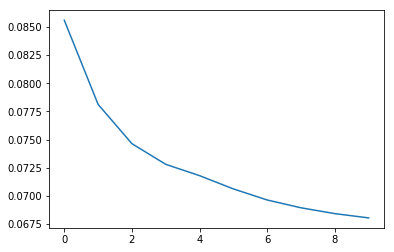

In [417]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
model.to(device)

lr, epochs, batch_size = 1e-1 , 10 , 10
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
i = 0
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        i =  i+1
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        output = model.forward(local_xy)
        output = output.to(device)
        #print(output)
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        #print(local_xy, local_xyz)
        if (i%500 == 0): print("network loss -> ", loss)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                                           

In [418]:
model.forward(torch.Tensor(obj).to(device), extract_z=True)

 vertexs_recovered: tensor([[ 0.7697, -0.3815, -0.7059,  0.8541,  0.9459, -0.1985, -0.5407,
          1.0282]], device='cuda:0')
 x[:,0,:]: tensor([[ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265]], device='cuda:0')
loss tensor(1.00000e-04 *
       6.5134, device='cuda:0')
z output vec: tensor([[ 0.1056, -0.9291,  0.2476,  0.0000,  0.1110, -0.9236,  0.2529,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0438,
         -0.0000, -0.0000, -0.0000, -0.4322, -0.0069, -0.0080, -0.0050,
         -0.0045, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')


tensor([[ 0.6459,  0.4539,  0.7028,  0.7240,  0.7935,  0.6045,  0.8322,
          0.8384]], device='cuda:0')

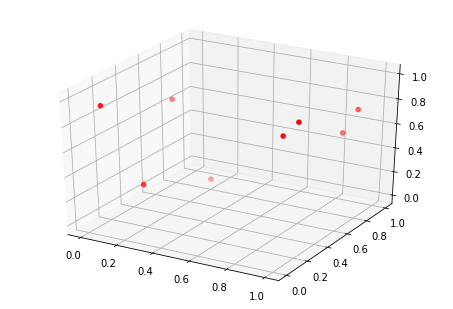

In [419]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
x = [ 0.7319, -0.4006, -0.7319,  0.8529,  0.9055, -0.2269, -0.5582,
          1.0265 ]
y =  [ 0.1290, -0.0706, -0.1290,  0.1504, -0.8558, -1.0554, -1.1139,
         -0.8344 ]
z = [ 0.6459,  0.4539,  0.7028,  0.7240,  0.7935,  0.6045,  0.8322,
          0.8384]
x=[(i-min(x))/(max(x)-min(x)) for i in x]
y=[(i-min(y))/(max(y)-min(y)) for i in y]
z=[(i-min(z))/(max(z)-min(z)) for i in z]

verts = [list(zip(x, y,z))]
#ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(x, y, z, c='r', marker='o')
plt.show()

Test Performance

In [16]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(test_xy[:,:,:], test_xyz[:,:,:])
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

cuda:0


/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


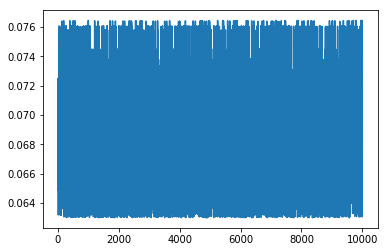

In [129]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
model.to(device)
criterion = nn.L1Loss()
lr, epochs, batch_size = 1e-1 , 1 , 1
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
i = 0
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        i =  i+1
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        local_xyz = local_xyz.to(device)
        output = model.forward(local_xy)
        output = output.to(device)
        #print("output:",output)
        #print("actual:", local_xyz[:,2,0:8])
        #loss = criterion(output, local_xyz[:,2,0:8])
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        
        #print(local_xy, local_xyz)
        #if (i%100 == 0): print("network loss -> ", loss)
        #model.zero_grad()
        #loss.backward()
        #optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(localaccum);                                           

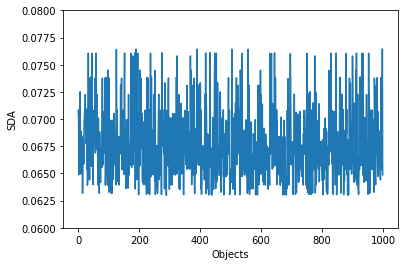

In [139]:
plt.ylabel('SDA')
plt.xlabel('Objects')
plt.ylim((0.06,0.08))
plt.plot(localaccum[0:1000])